### Library

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dataset

In [ ]:
df = pd.read_csv('/content/Food_Delivery_Times.csv')
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [ ]:
df.columns

Index(['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min'],
      dtype='object')

In [ ]:
len(df)

1000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


Interpretasi: Terdapat indikasi missing value, maka nanti kita akan mengecek pada data preparation. Selain itu, terdapat 4 variabel kategorik, yaitu weather, traffic_level, time_of_day, dan Vehicle_type dan sisanya variabel numerik, yaitu Distance_km, preparation_time_min, courier_experience_yrs, dan **delivery_time_min (sebagai variabel Target)**

## Business Understanding / Permasalahan Masalah

**Keterlambatan dalam pengiriman makanan** merupakan keluhan paling umum dari pelanggan layanan pengantar makanan. Hal ini, dapat mengakibatkan mengurangi kepuasan pelanggan, menimbulkan ulasan negatif baik dari sisi pengantar ataupun outlet yang diorder, hingga berdampak **pada loyalitas pelanggan** dimana akhirnya pelanggan tidak akan percaya lagi untuk melakukan layanan order pada outlet dan pengantaran yang sama di suatu aplikasi.

Hal ini, mengapa bisa terjadi keterlambatan pengiriman makanan?. Ketepatan/Terlambatnya pengiriman makanan tergantung beberapa faktor:
- Seperti **jarak pengantaran** dimana semakin jauh maka pengantaran akan semakin pula karena membutuhkan waktu yang tidak cukup cepat dalam proses pengantaran.
- Kemudian **kondisi cuaca dan adanya traffic light** ini juga memengaruhi pengantaran karena cuaca buruk akan memperlambat proses pengantaran, misalnya terjadi hujan ataupun badai dan juga banyaknya traffic light akan memeprlama waktu akrena memperlambat tersampainya pesanan apalagi kalau kondisi macet.
- **Waktu pengantaran** juga memengaruhi proses pengantaran karena semakin cepat pengantaran maka akan semakin senang pelanggan ketika pesanannya sudah sampai tepat waktu.
- **Jenis kendaraan** juga bisa memengaruhi, karena bergantung pada kecepatan,  waktu, dan jarak juga, jikalau memakai sepeda maka waktu akan cukup lebih lama, apalagi kondisi jarak pengantaran cukup jauh belum lagi kalau kondisi cuaca yang tidak mendukung.
- **Waktu persiapan** juga bisa memengaruhi, ketika persiapannya tidak tepat waktu maka akan memperlama proses pengantaran pesanan.
- Dan terakhir juga bisa **pengalaman pengantar (pengalaman kurir)** karena kurir akan tau bagaimana kinerja cepat dan tepat, kemudian dengan keadaan-keadaan yang mendesak atau tidak memungkinkan, kemungkinan kurir juga akan mengetahui bagaimana caranya supaya bisa mengantar dengan tepat dan cepat.

Sebagai seorang **data scientist**, saya ingin memprediksi waktu pengantaran yang optimal untuk **meminimalkan risiko keterlambatan** dalam proses pengiriman. Hal ini bertujuan untuk memudahkan kurir dalam menjalankan tugasnya dan membantu perusahaan dalam menjaga reputasinya. Kepuasan serta loyalitas pelanggan merupakan faktor penting yang dapat meningkatkan keuntungan perusahaan. Oleh karena itu, penerapan machine learning dalam prediksi waktu pengantaran makanan menjadi langkah yang relevan. Mengingat tingginya persaingan di industri pengantaran makanan, seperti dengan perusahaan-perusahaan besar seperti Gojek dan lainnya, inisiatif ini bertujuan untuk **mengembangkan perusahaan agar semakin menarik minat pelanggan, meningkatkan kualitas layanan, dan memperkuat posisi perusahaan di pasar**.

## Data Understanding

- Order_ID: Merupakan identifikasi unik untuk setiap pesanan. Variabel ini bersifat kategorikal dan tidak memiliki hubungan langsung dengan target (waktu pengantaran), namun bisa digunakan untuk tujuan pengelompokan.


- Distance_km: Mengukur jarak pengiriman dalam kilometer. Variabel ini numerik dan dapat diperkirakan memiliki pengaruh langsung terhadap waktu pengiriman.

- Weather: Menyediakan informasi mengenai kondisi cuaca saat pengiriman, seperti Clear, Rainy, Snowy, Foggy, dan Windy. Variabel ini bersifat kategorikal dan bisa mempengaruhi kecepatan pengiriman, misalnya dalam kondisi cuaca buruk seperti hujan atau salju.

- Traffic_Level: Kategori kondisi lalu lintas (Low, Medium, High). Ini juga merupakan variabel kategorikal yang sangat berpengaruh pada waktu pengiriman. Semakin tinggi level lalu lintas, semakin lama waktu pengantaran.

- Time_of_Day: Waktu pengiriman yang dibagi menjadi kategori Morning, Afternoon, Evening, dan Night. Variabel ini bisa membantu dalam menentukan pola pengiriman di waktu tertentu dan bagaimana kondisi lalu lintas atau permintaan berubah sepanjang hari.

- Vehicle_Type: Menunjukkan jenis kendaraan yang digunakan dalam pengiriman, seperti Bike, Scooter, atau Car. Variabel ini bersifat kategorikal dan kemungkinan berpengaruh terhadap kecepatan pengiriman, tergantung pada jenis kendaraan yang digunakan.

- Preparation_Time_min: Waktu yang dibutuhkan untuk mempersiapkan makanan sebelum dikirim, diukur dalam menit. Ini adalah variabel numerik yang penting karena mempengaruhi total waktu pengiriman.

- Courier_Experience_yrs: Pengalaman kurir dalam tahun. Variabel numerik ini dapat mempengaruhi kecepatan pengiriman, dengan kurir yang lebih berpengalaman kemungkinan lebih efisien.

- Delivery_Time_min: Waktu total pengiriman dalam menit. Ini adalah variabel target yang ingin diprediksi dengan menggunakan variabel-variabel lainnya.

# Data Preprocessing (EDA)

## Missing Values

In [ ]:
## Melihat data yang missing value
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percent.round(2)
})

missing_df[missing_df['Missing Values'] > 0]  # tampilkan hanya yang ada missing-nya

,Missing Values,Percentage (%)
Weather,30,3.0
Traffic_Level,30,3.0
Time_of_Day,30,3.0
Courier_Experience_yrs,30,3.0


Interpretasi: ternyata terdapat missing values dari 3 variabel kategorik, yaitu **weather, traffic_level, dan time_of_day**, sekaligus 1 variabel numerik yaitu **courier_experience_yrs**. Karena, persentase <20%, maka dilakukan handling dengan pendekatan imputasi missing values, yaitu mean, median, atau modus (untuk kategorik)

### Handling Missing Values

Karena dilakukan handling, maka:
- **Variabel numerik**: menggunakan pendekatan mean atau median. Sebelumnya, kita perlu cek distirbusi data dulu apakah cocok menggunakan mean/median. Jikalau, ada indikasi skewness maka menggunakan median (karena robust outlier)
- **Variabel kategori**k: menggunakan modus

#### Numerik

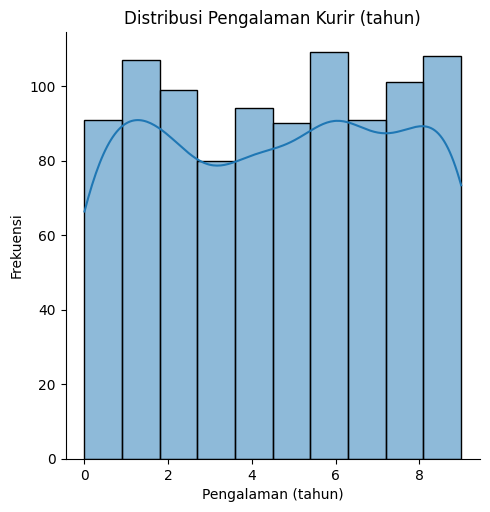

In [ ]:
# Plotting the distribution using a seaborn displot in Indonesian
sns.displot(df['Courier_Experience_yrs'].dropna(), kde=True, bins=10)
plt.title('Distribusi Pengalaman Kurir (tahun)')
plt.xlabel('Pengalaman (tahun)')
plt.ylabel('Frekuensi')
plt.show()


Interpretasi: Grafik histogram pada variabel 'Courier Experience Year' menunjukkan bahwa distribusinya cenderung tampak cukup simetris dengan beberapa fluktuasi kecil pada bagian-bagian tertentu. Namun, tidak terlihat adanya skewness yang jelas (baik ke kiri atau ke kanan). Artinya, distribusi data terlihat relatif normal atau mendekati distribusi simetris. **Sehingga, imputasi yang cocok menggunakan mean.**

In [ ]:
# Imputasi dengan Mean
df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].mean(), inplace=True)

<ipython-input-8-5071549af725>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].mean(), inplace=True)


In [ ]:
#Recheck
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percent.round(2)
})

missing_df[missing_df['Missing Values'] > 0]  # tampilkan hanya yang ada missing-nya

,Missing Values,Percentage (%)
Weather,30,3.0
Traffic_Level,30,3.0
Time_of_Day,30,3.0


Lanjut ke variabel kategorik menggunakan modus.

#### Kategorik

In [ ]:
kolom_kategori = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

for kolom in kolom_kategori:
    df[kolom].fillna(df[kolom].mode()[0], inplace=True)

<ipython-input-10-764f702d23a3>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[kolom].fillna(df[kolom].mode()[0], inplace=True)


In [ ]:
#Recheck
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percent.round(2)
})

missing_df[missing_df['Missing Values'] > 0]  # tampilkan hanya yang ada missing-nya

,Missing Values,Percentage (%)


Oke data sudah bersih

## Cek Value Aneh

In [ ]:
# Cek value_counts untuk mendeteksi nilai yang aneh di kolom kategorikal
df_kolom = ['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min']
for column in df_kolom:
    print(f"============= {column} =================")
    display(df[column].value_counts(dropna=False))  # dropna=False untuk lihat missing juga kalau ada
    print()

============= Distance_km =================


,count
Distance_km,
12.85,5
19.41,4
17.61,4
19.74,3
12.74,3
...,...
1.62,1
6.05,1
10.14,1



============= Weather =================


,count
Weather,
Clear,500
Rainy,204
Foggy,103
Snowy,97
Windy,96



============= Traffic_Level =================


,count
Traffic_Level,
Medium,420
Low,383
High,197



============= Time_of_Day =================


,count
Time_of_Day,
Morning,338
Evening,293
Afternoon,284
Night,85



============= Vehicle_Type =================


,count
Vehicle_Type,
Bike,503
Scooter,302
Car,195



============= Preparation_Time_min =================


,count
Preparation_Time_min,
14,52
16,49
25,48
10,47
11,46
9,46
17,45
6,44
8,42



============= Courier_Experience_yrs =================


,count
Courier_Experience_yrs,
6.000000,109
9.000000,108
1.000000,107
8.000000,101
2.000000,99
4.000000,94
7.000000,91
0.000000,91
5.000000,90



============= Delivery_Time_min =================


,count
Delivery_Time_min,
71,23
44,22
48,22
43,21
51,21
...,...
103,1
99,1
126,1


Data tidak ada yang aneh, jadi lanjut duplikasi data

## Duplikasi Data

In [ ]:
# Mengecek duplikasi data
duplikat = df.duplicated()

# Menampilkan baris yang duplikat
df_duplikat = df[duplikat]

# Menampilkan jumlah baris duplikat
jumlah_duplikat = duplikat.sum()

print(f'Jumlah duplikat: {jumlah_duplikat}')
print('Baris duplikat:')


Jumlah duplikat: 0
Baris duplikat:


Tidak ada duplikasi data, maka lanjut ke deteksi outliers

## Cek Outliers

Pengecekan dilakukan pada variabel-variabel numerik, seperti: **Preparation_Time_min, Courier_Experience_yrs, Distance_km, dan Delivery_Time_min**

In [ ]:
# Kolom numerik
numerik_df = ['Preparation_Time_min', 'Courier_Experience_yrs', 'Distance_km', 'Delivery_Time_min']

Variabel Preparation_Time_min:


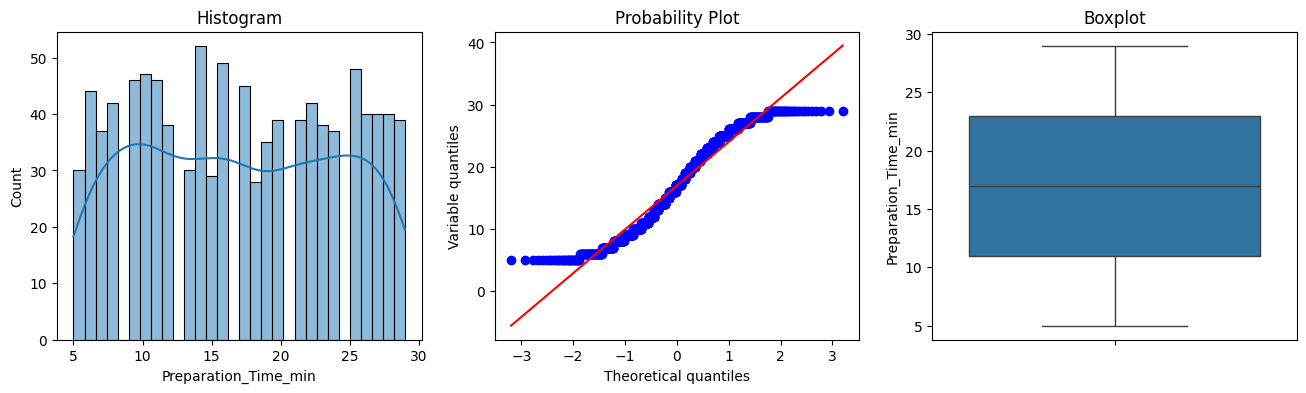

Variabel Courier_Experience_yrs:


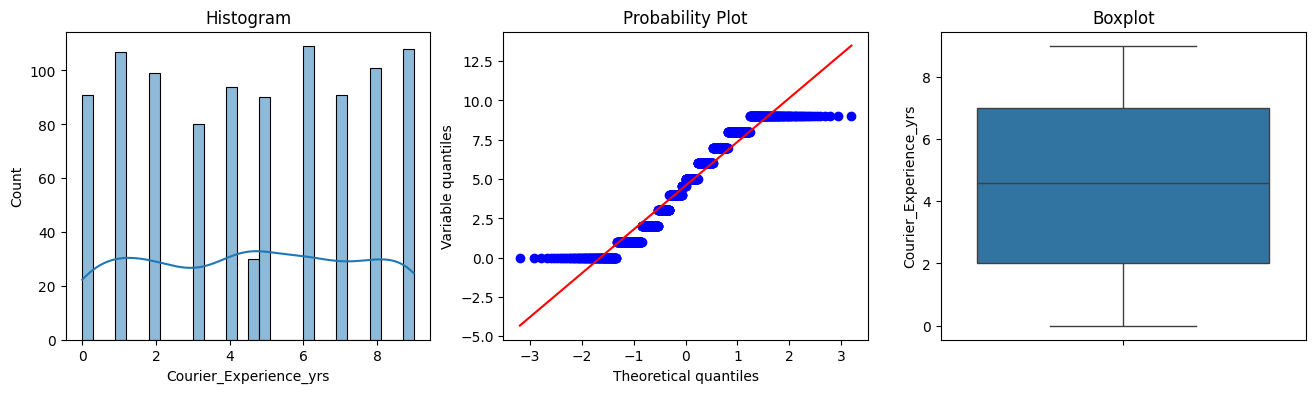

Variabel Distance_km:


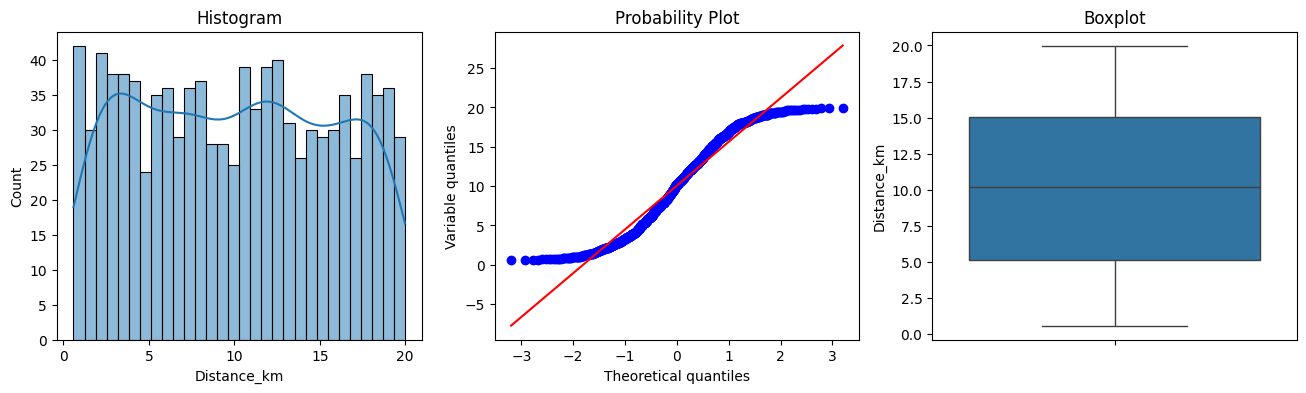

Variabel Delivery_Time_min:


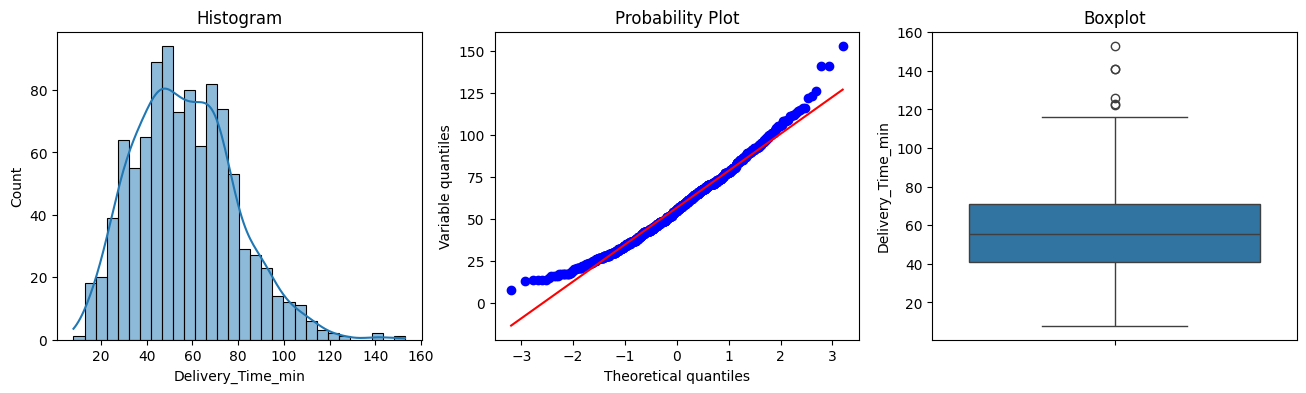

In [ ]:
#Cek dengan plot
def check_outlier(df, variable):

  print(f'Variabel {variable}:')

  #ukuran gambar
  plt.figure(figsize=(16,4))

  #histogram
  plt.subplot(1, 3, 1)
  sns.histplot(df[variable], kde=True, bins=30)
  plt.title('Histogram')

  #boxplot
  plt.subplot(1, 3, 3)
  sns.boxplot(y=df[variable])
  plt.title('Boxplot')


  #probplot
  plt.subplot(1, 3, 2)
  stats.probplot(df[variable], dist="norm", plot=plt)
  plt.ylabel('Variable quantiles')

  plt.show()

for i in numerik_df:
  check_outlier(df, i)

Interpretasi:
- Variabel Preparation_Time_mi, Courier_Experience_yrs, dan distance_km, secara histogram tidak menunjukkan adanya skewness dalam artian hampir simetris, kemudian QQ plot titik-titiknya mendekati garis linear, dan secara boxplot tidak ada nilai ekstrem. Maka, tidak ada indikasi outlier
- Variabel Delivery_Time_min, secara histogram menunjukkan bahwa distribusinya skewness positif, kemudian QQ plot titik-titiknya mendekati garis linear tetapi ada beberapa titik yang menjauhi garis linear (cenderung outlier), dan secara boxplot terdapat beberapa nilai ekstrem. **Sehingga, perlu dicek dan dilakukan handling outlier dengan pendekatan IQR**

#### Handling Outliers

In [ ]:
data = ['Delivery_Time_min']
def detect_outlier_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"\nKolom: {column}")
    print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"Jumlah outlier: {outliers.shape[0]}")

    return outliers.index

# Kumpulkan semua indeks outlier dari seluruh kolom numerik
outlier_indices = set()

for col in data:
    indices = detect_outlier_iqr(df, col)
    outlier_indices.update(indices)

# Drop semua baris outlier dari dataframe
df_clean = df.drop(index=outlier_indices)

print(f"\nJumlah baris setelah menghapus outlier: {df_clean.shape[0]}")


Kolom: Delivery_Time_min
Q1: 41.00, Q3: 71.00, IQR: 30.00
Lower Bound: -4.00, Upper Bound: 116.00
Jumlah outlier: 6

Jumlah baris setelah menghapus outlier: 994


In [ ]:
df_clean

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68
...,...,...,...,...,...,...,...,...,...
995,107,8.50,Clear,High,Evening,Car,13,3.0,54
996,271,16.28,Rainy,Low,Morning,Scooter,8,9.0,71
997,861,15.62,Snowy,High,Evening,Scooter,26,2.0,81
998,436,14.17,Clear,Low,Afternoon,Bike,8,0.0,55


In [ ]:
len(df_clean)

994

Variabel Preparation_Time_min:


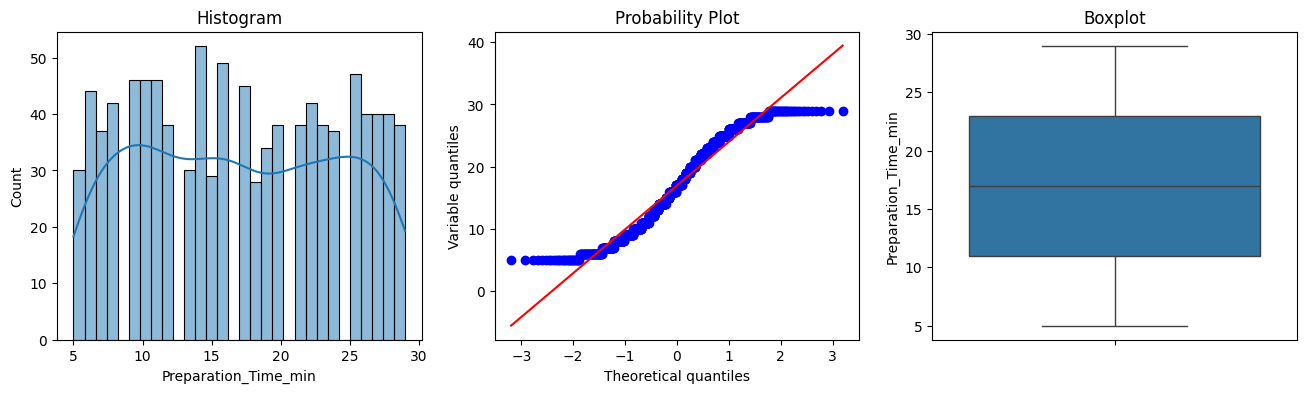

Variabel Courier_Experience_yrs:


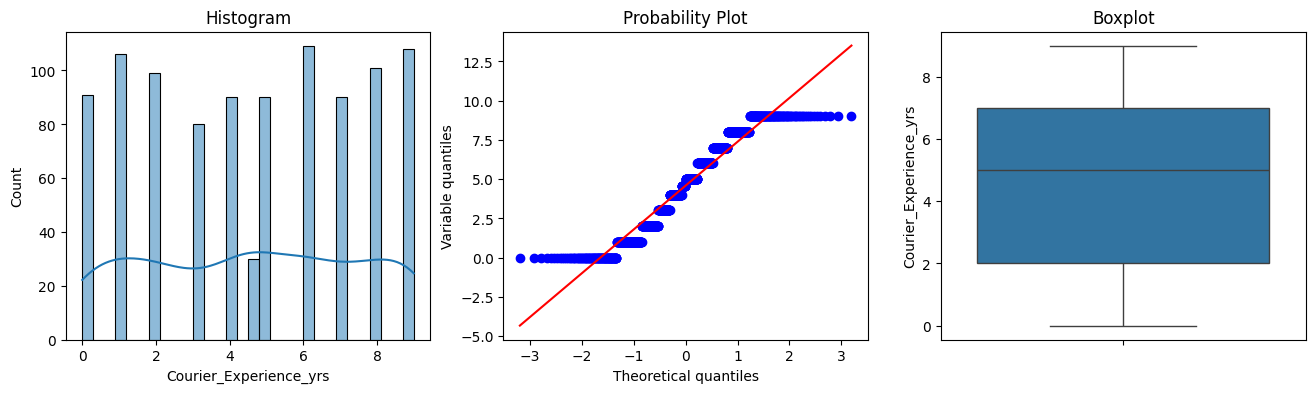

Variabel Distance_km:


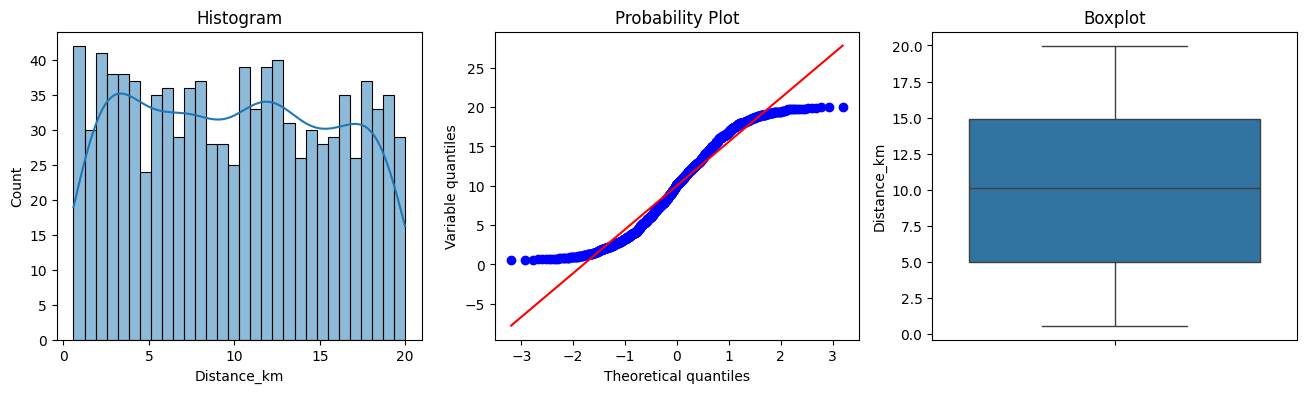

Variabel Delivery_Time_min:


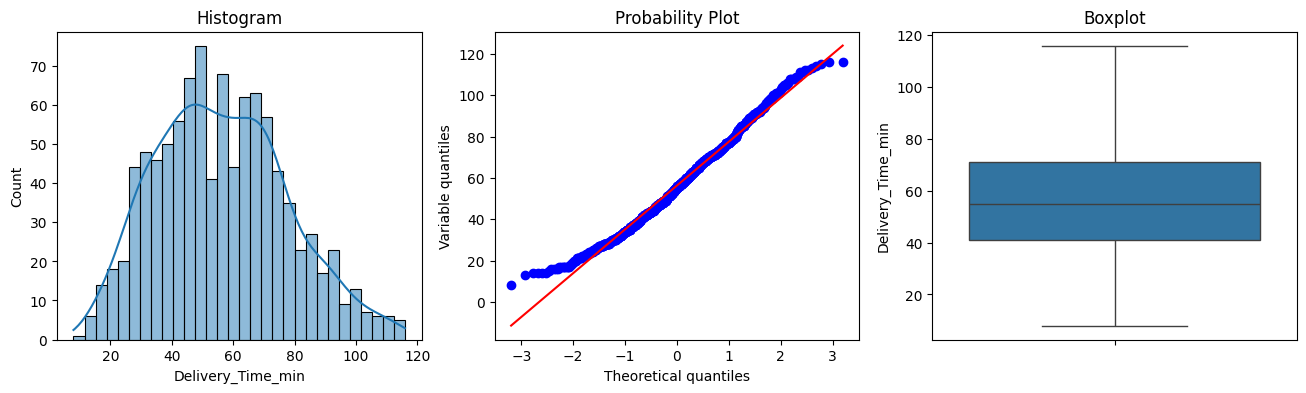

In [ ]:
#Recheck
#Cek dengan plot
def check_outlier(df, variable):

  print(f'Variabel {variable}:')

  #ukuran gambar
  plt.figure(figsize=(16,4))

  #histogram
  plt.subplot(1, 3, 1)
  sns.histplot(df[variable], kde=True, bins=30)
  plt.title('Histogram')

  #boxplot
  plt.subplot(1, 3, 3)
  sns.boxplot(y=df[variable])
  plt.title('Boxplot')


  #probplot
  plt.subplot(1, 3, 2)
  stats.probplot(df[variable], dist="norm", plot=plt)
  plt.ylabel('Variable quantiles')

  plt.show()

for i in numerik_df:
  check_outlier(df_clean, i)

Interpretasi: Okay data pada variabel-variabel tersebut (**Preparation_Time_min, Courier_Experience_yrs, Distance_km, dan Delivery_Time_min**) sudah tidak ada outlier, karena: distirbusi secara histogram cenderung simetris dan tidak membentuk skewness, kemudian secara QQ plot dimana data-datanya mendekati garis linear, dan secara boxxplot menunjukkan bahwa tidak ada nilai ekstrem.

### Penyimpanan untuk EDA 2 (Business Key Insights)

In [ ]:
df_EDA2 = df_clean.copy()

### Business Key Insights

#### 1. Bagaimana hubungan jarak terhadap waktu pengiriman?

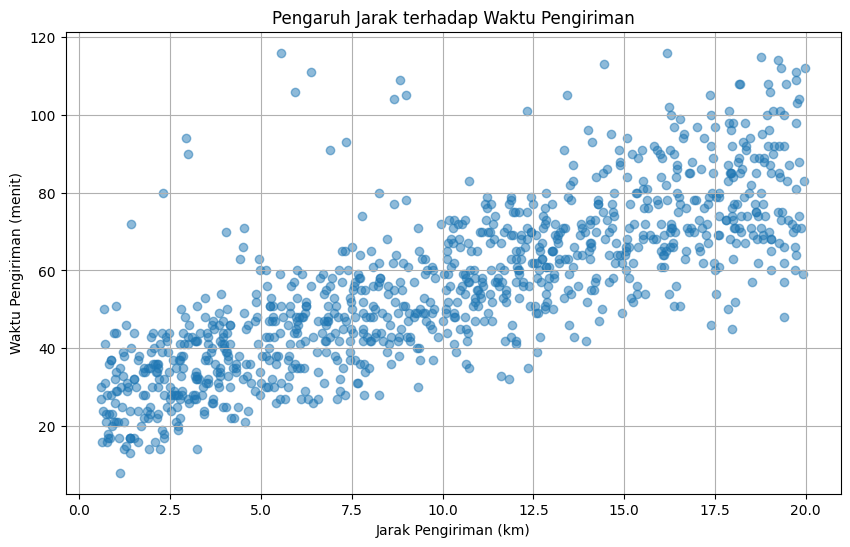

In [ ]:
# Scatter plot untuk menunjukkan hubungan antara Distance_km dan Delivery_Time_min
plt.figure(figsize=(10, 6))
plt.scatter(df_EDA2['Distance_km'], df_EDA2['Delivery_Time_min'], alpha=0.5)
plt.title('Pengaruh Jarak terhadap Waktu Pengiriman')
plt.xlabel('Jarak Pengiriman (km)')
plt.ylabel('Waktu Pengiriman (menit)')
plt.grid(True)
plt.show()

Interpretasi: Terdapat hubungan antara jarak dan waktu pengiriman, dimana semakin jauh jarak yang ditempuh maka semakin banyak waktu yang ddibutuhkan. Sehingga, dalam case pengantaran pesanan, ya memang kalau jarak konsumen cukup jauh dari resto (kebutuhan yang dipesan), maka waktunya juga cukup lama untuk sampai ke konsumen.

#### 2. Kita pengen tahu, Jumlah pesanan berdasarkan kondisi cuaca gimana ?

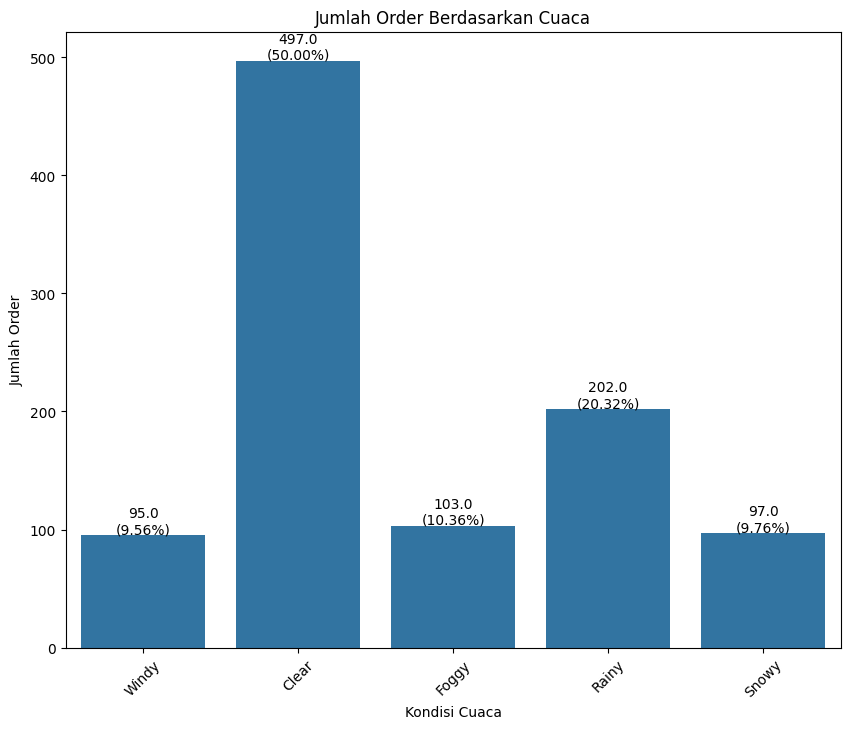

In [ ]:
# Membuat countplot untuk jumlah Order berdasarkan kondisi cuaca
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=df_EDA2, x='Weather')

# Menghitung jumlah total order
total_orders = len(df_EDA2)

# Menambahkan angka dan persentase di atas setiap batang
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_orders) * 100
    ax.annotate(f'{height}\n({percentage:.2f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha = 'center', va = 'center',
                fontsize=10, color='black',
                xytext=(0, 10), textcoords='offset points')

# Menambahkan judul dan label
plt.title("Jumlah Order Berdasarkan Cuaca")
plt.xlabel("Kondisi Cuaca")
plt.ylabel("Jumlah Order")
plt.xticks(rotation=45)
plt.show()


Interpretasi: Jumlah Order/Pesanan yang paling banyak terjadi pada kondisi cuaca terang. Hal ini, menunjukkan bahwa memang sebenarnya kecenderungan pengantar pesanan online kondisi cuaca terang lebih banyak dibandingkan selain terang karena bisa menghambat proses pengantaran. Kita breakdown lagi, untuk cuaca Terang dan Rainy.

#### 3. Bagaimana jumlah order/pesanan dengan kondisi Cuaca ‘Terang’ dan ‘Rainy’ berdasarkan Waktu Pengirimannya ?

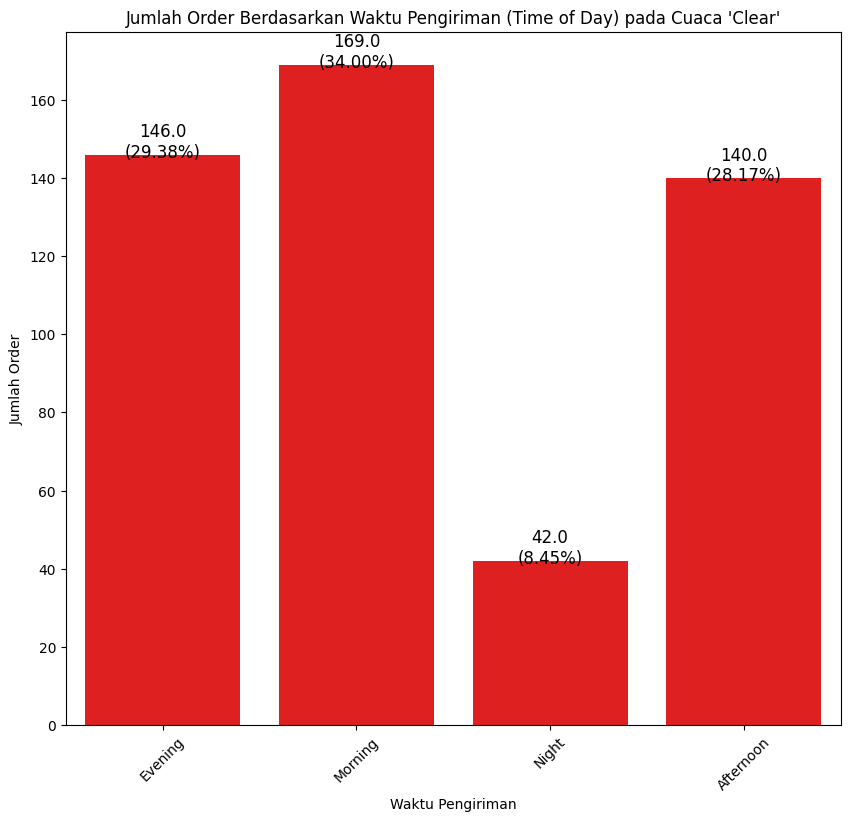

In [ ]:
# Filter data untuk hanya mengambil cuaca 'Clear'
clear_weather_data = df_EDA2[df_EDA2['Weather'] == 'Clear']

# Membuat countplot untuk melihat banyaknya pesanan berdasarkan 'Time_of_Day' pada cuaca 'Clear'
plt.figure(figsize=(10, 9))
ax = sns.countplot(data=clear_weather_data, x='Time_of_Day', color='red')

# Menghitung jumlah total order untuk cuaca 'Clear'
total_clear_orders = len(clear_weather_data)

# Menambahkan angka dan persentase di atas setiap batang
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_clear_orders) * 100
    ax.annotate(f'{height}\n({percentage:.2f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 9), textcoords='offset points')

# Menambahkan judul dan label
plt.title("Jumlah Order Berdasarkan Waktu Pengiriman (Time of Day) pada Cuaca 'Clear'")
plt.xlabel("Waktu Pengiriman")
plt.ylabel("Jumlah Order")
plt.xticks(rotation=45)
plt.show()


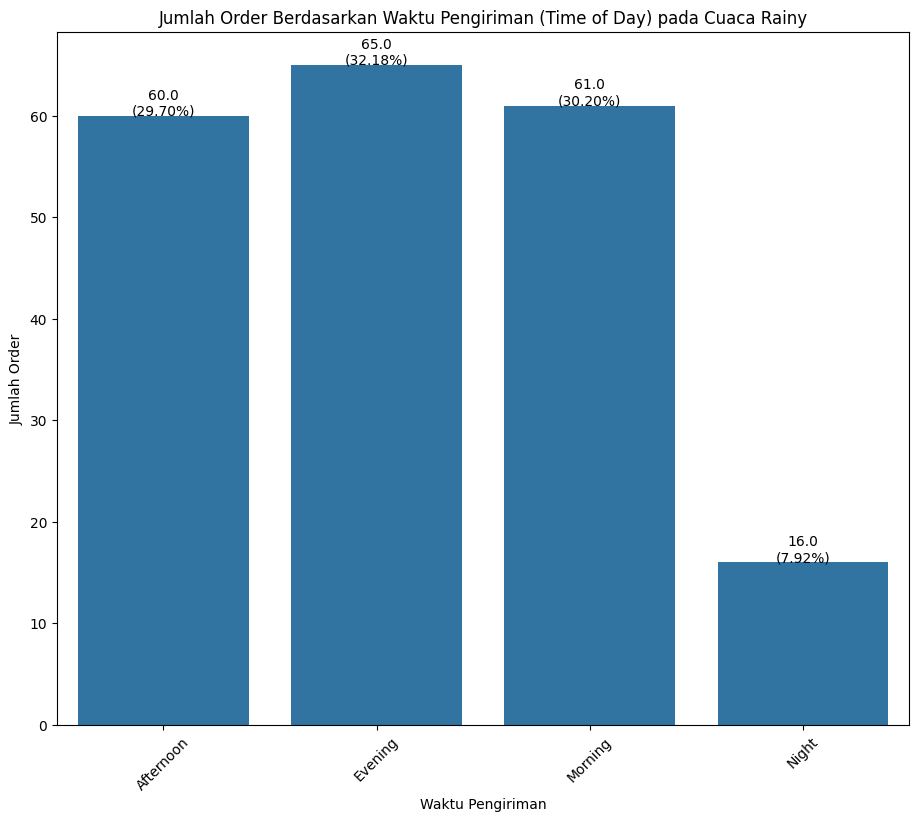

In [ ]:
# Filter data untuk hanya mengambil cuaca 'Rainy'
rainy_weather_data = df_EDA2[df_EDA2['Weather'] == 'Rainy']

# Membuat countplot untuk melihat banyaknya pesanan berdasarkan 'Time_of_Day' pada cuaca 'Rainy'
plt.figure(figsize=(11, 9))
ax = sns.countplot(data=rainy_weather_data, x='Time_of_Day')

# Menghitung jumlah total order untuk cuaca 'Rainy'
total_rainy_orders = len(rainy_weather_data)

# Menambahkan angka dan persentase di atas setiap batang
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_rainy_orders) * 100
    ax.annotate(f'{height}\n({percentage:.2f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 9), textcoords='offset points')

# Menambahkan judul dan label
plt.title("Jumlah Order Berdasarkan Waktu Pengiriman (Time of Day) pada Cuaca Rainy")
plt.xlabel("Waktu Pengiriman")
plt.ylabel("Jumlah Order")
plt.xticks(rotation=45)
plt.show()


Interpretasi kedua chart:
- Sebagian besar pelanggan memesan makanan pada pagi hari saat cuaca cerah, kemungkinan karena terburu-buru berangkat kerja dan tidak sempat menyiapkan sarapan. Hal ini mencerminkan gaya hidup praktis masyarakat urban yang mengandalkan layanan pengantaran.
- Sementara itu, pada cuaca hujan, pemesanan lebih banyak terjadi di sore hari. Kondisi hujan membuat pelanggan enggan keluar rumah atau kantor, sehingga lebih memilih memesan makanan. Selain itu, cuaca dingin juga meningkatkan keinginan untuk mengonsumsi makanan hangat.

#### 4. Fokus pada cuaca Rainy, bagaimana rata-rata waktu pengiriman berdasarkan masing-masing kategori waktu (pagi, siang, sore, malam)?


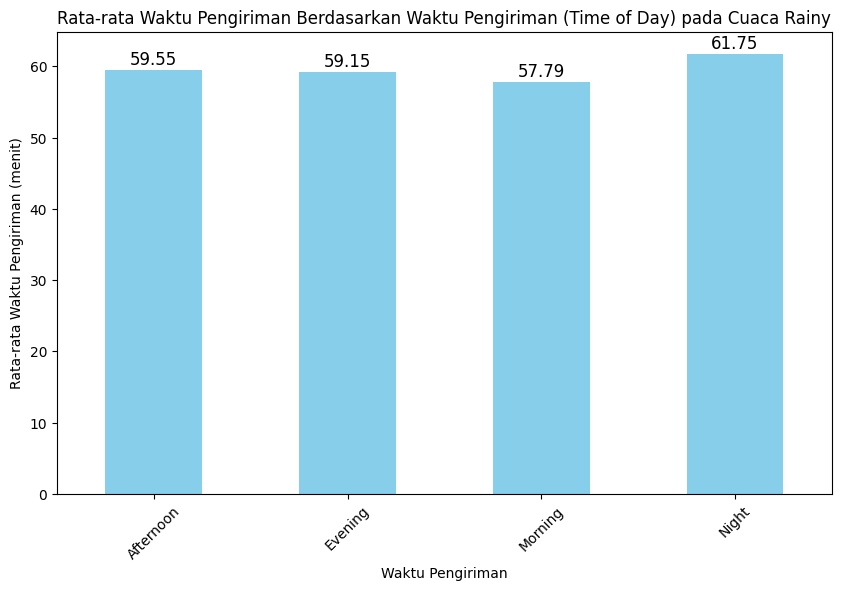

In [ ]:
# Filter data untuk hanya mengambil cuaca 'Rainy'
rainy_weather_data = df_EDA2[df_EDA2['Weather'] == 'Rainy']

# Menghitung rata-rata Delivery_Time_min berdasarkan Time_of_Day
avg_delivery_time = rainy_weather_data.groupby('Time_of_Day')['Delivery_Time_min'].mean()

# Membuat bar plot untuk menunjukkan rata-rata waktu pengiriman berdasarkan Time_of_Day
plt.figure(figsize=(10, 6))
avg_delivery_time.plot(kind='bar', color='skyblue')

# Menambahkan angka di atas setiap batang
for i, value in enumerate(avg_delivery_time):
    plt.text(i, value + 0.2, f'{value:.2f}', ha='center', va='bottom', fontsize=12)

# Menambahkan judul dan label
plt.title("Rata-rata Waktu Pengiriman Berdasarkan Waktu Pengiriman (Time of Day) pada Cuaca Rainy")
plt.xlabel("Waktu Pengiriman")
plt.ylabel("Rata-rata Waktu Pengiriman (menit)")
plt.xticks(rotation=45)
plt.show()

Interpretasi:
Rata-rata waktu pengiriman saat cuaca hujan hampir mencapai 1 jam, terutama tinggi pada malam hari. Hal ini kemungkinan disebabkan oleh jarak tempuh yang jauh, kondisi jalan yang gelap, dan kurir yang harus lebih berhati-hati atau menunggu hujan reda. Situasi ini meningkatkan risiko keterlambatan, terutama pada jam sibuk, sehingga penting untuk mempertimbangkan cuaca dan waktu dalam estimasi pengiriman.

#### 5. Berdasarkan kondisi cuaca hujan (Rainy), berapa rata-rata jarak tempuh pengiriman yang menyebabkan estimasi waktu pengiriman mendekati satu jam?

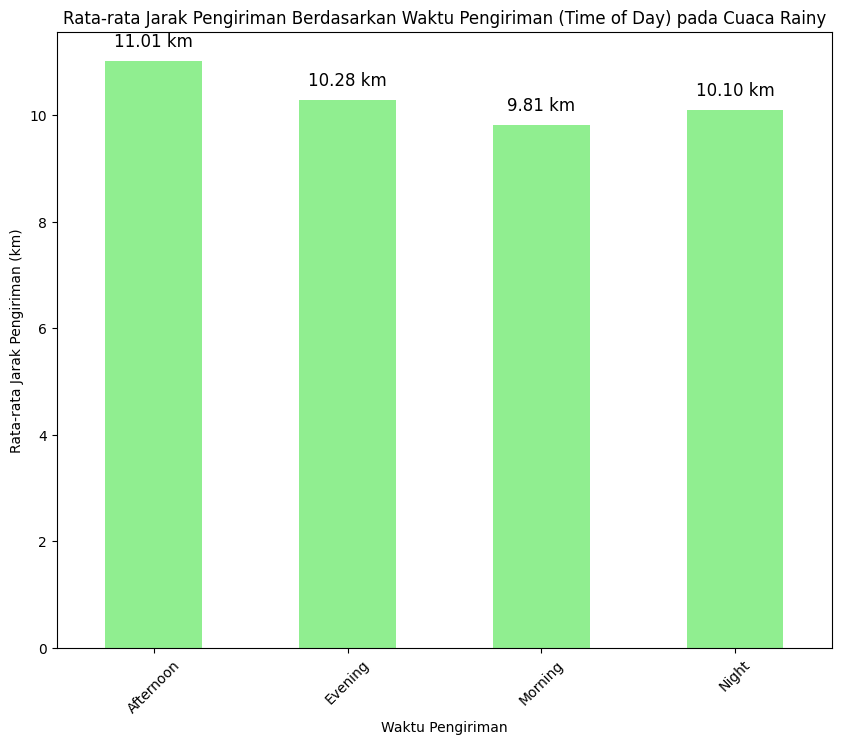

In [ ]:
# Menghitung rata-rata jarak pengiriman berdasarkan Time_of_Day
avg_distance = rainy_weather_data.groupby('Time_of_Day')['Distance_km'].mean()

# Membuat bar plot untuk menunjukkan rata-rata jarak pengiriman berdasarkan Time_of_Day
plt.figure(figsize=(10, 8))
avg_distance.plot(kind='bar', color='lightgreen')

# Menambahkan angka di atas setiap batang
for i, value in enumerate(avg_distance):
    plt.text(i, value + 0.2, f'{value:.2f} km', ha='center', va='bottom', fontsize=12)

# Menambahkan judul dan label
plt.title('Rata-rata Jarak Pengiriman Berdasarkan Waktu Pengiriman (Time of Day) pada Cuaca Rainy')
plt.xlabel('Waktu Pengiriman')
plt.ylabel('Rata-rata Jarak Pengiriman (km)')
plt.xticks(rotation=45)
plt.show()

Interpretasi:
Rata-rata jarak pengiriman saat cuaca hujan (Rainy) mencapai hampir 10 km, dengan jarak tertinggi tercatat pada sore hari. Kondisi ini menunjukkan bahwa kombinasi antara cuaca buruk dan jarak tempuh yang relatif jauh berkontribusi signifikan terhadap lamanya waktu pengiriman, yang mendekati 1 jam. Situasi tersebut memperkuat indikasi adanya risiko keterlambatan, terutama di waktu-waktu padat, sehingga penting bagi perusahaan untuk mempertimbangkan faktor cuaca dan jarak dalam perencanaan operasional pengantaran.

#### 6. Bagaimana perbandingan kondisi lalu lintas antara cuaca cerah (Clear) dan hujan (Rainy)?

<ipython-input-27-2b0992594be3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=rainy_weather_data, x='Traffic_Level', palette='Set2')


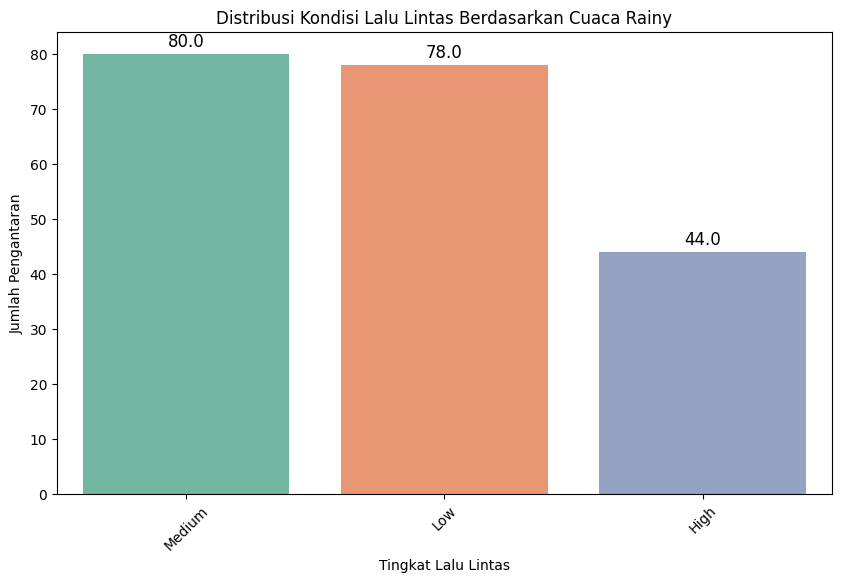

In [ ]:
# Filter data untuk hanya mengambil cuaca 'Rainy'
rainy_weather_data = df_EDA2[df_EDA2['Weather'] == 'Rainy']

# Membuat countplot untuk menunjukkan distribusi Traffic_Level pada cuaca 'Rainy'
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=rainy_weather_data, x='Traffic_Level', palette='Set2')

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 9), textcoords='offset points')

# Menambahkan judul dan label
plt.title('Distribusi Kondisi Lalu Lintas Berdasarkan Cuaca Rainy')
plt.xlabel('Tingkat Lalu Lintas')
plt.ylabel('Jumlah Pengantaran')
plt.xticks(rotation=45)
plt.show()

<ipython-input-28-74e01aaf1fc0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=rainy_weather_data, x='Traffic_Level', palette='Set2')


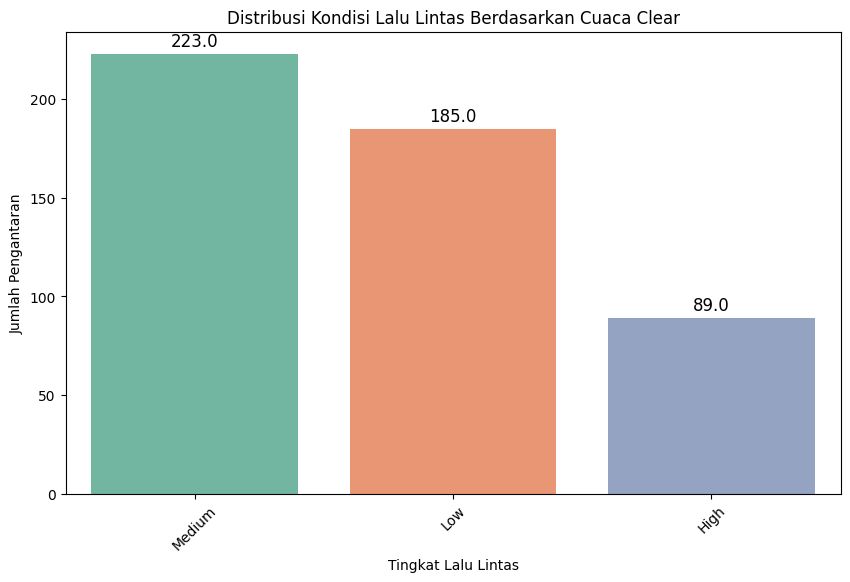

In [ ]:
# Filter data untuk hanya mengambil cuaca 'Clear'
rainy_weather_data = df_EDA2[df_EDA2['Weather'] == 'Clear']

# Membuat countplot untuk menunjukkan distribusi Traffic_Level pada cuaca 'Clear'
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=rainy_weather_data, x='Traffic_Level', palette='Set2')

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 9), textcoords='offset points')

# Menambahkan judul dan label
plt.title('Distribusi Kondisi Lalu Lintas Berdasarkan Cuaca Clear')
plt.xlabel('Tingkat Lalu Lintas')
plt.ylabel('Jumlah Pengantaran')
plt.xticks(rotation=45)
plt.show()

Interpretasi:
Meskipun pengantaran dilakukan saat hujan, mayoritas distribusi lalu lintas berada di tingkat Low hingga Medium. Hal ini kemungkinan karena masyarakat cenderung membatasi aktivitas luar ruang saat cuaca buruk, sehingga alalu lintas menjadi lebih lengang. Kurir dapat memanfaatkan kondisi ini dengan efisiensi rute dan pengalaman, meskipun tetap harus berhati-hati. Temuan ini menegaskan bahwa risiko keterlambatan lebih banyak dipengaruhi oleh faktor cuaca dan jarak tempuh, bukan semata kepadatan lalu lintas.

### (Deep Dive Analysis) - Dari Segi Jarak Pengiriman

#### 7. Breakdown Jarak pengiriman sebagai salah satu faktor keterlambatan

In [ ]:
rata2_jarak = df_EDA2['Distance_km'].mean()
print(f'Rata-rata jarak pengiriman: {rata2_jarak:.2f} km')

Rata-rata jarak pengiriman: 10.02 km


In [ ]:
def jarak_kategori(jarak):
    if jarak < 5:
        return 'Dekat'
    elif jarak < 10:
        return 'Sedang'
    else:
        return 'Jauh'

df_EDA2['Range_Jarak'] = df_EDA2['Distance_km'].apply(jarak_kategori)

<ipython-input-63-2f0ce176375d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_kategori.index, y=count_kategori.values, palette='viridis')
<ipython-input-63-2f0ce176375d>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent_text = f"{percentages[i]:.1f}%"


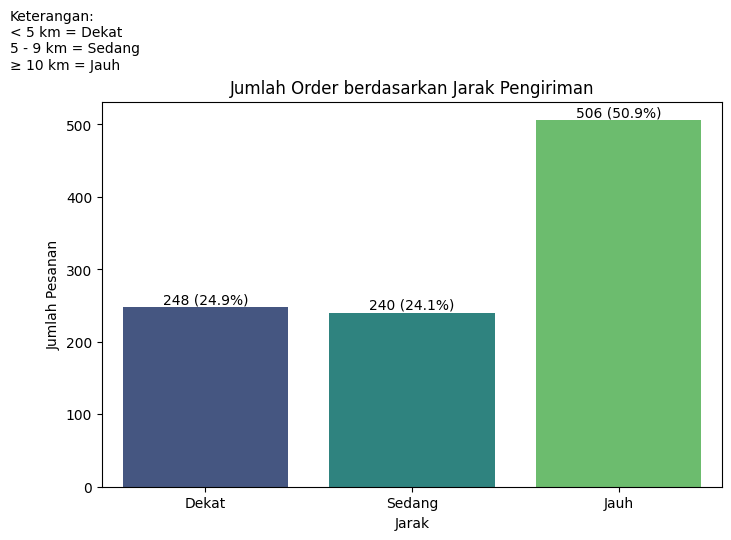

In [ ]:
count_kategori = df_EDA2['Range_Jarak'].value_counts().reindex(['Dekat', 'Sedang', 'Jauh'])

total = count_kategori.sum()
percentages = (count_kategori / total) * 100

plt.figure(figsize=(8,5))
ax = sns.barplot(x=count_kategori.index, y=count_kategori.values, palette='viridis')

plt.title('Jumlah Order berdasarkan Jarak Pengiriman')
plt.xlabel('Jarak')
plt.ylabel('Jumlah Pesanan')

for i, v in enumerate(count_kategori.values):
    percent_text = f"{percentages[i]:.1f}%"
    ax.text(i, v + max(count_kategori.values)*0.01, f"{v} ({percent_text})", color='black', ha='center')

# Keterangan di sisi kiri atas
plt.figtext(0.01, 0.95, 'Keterangan:\n< 5 km = Dekat\n5 - 9 km = Sedang\n≥ 10 km = Jauh',
            wrap=True, horizontalalignment='left', fontsize=10)

plt.show()


Interpretasi:

- Jarak Pengiriman Dekat (< 5 km): Sebanyak 248 pesanan (24.9%) berada dalam kategori jarak dekat. Ini menunjukkan bahwa jumlah pesanan dengan jarak dekat cukup signifikan meskipun tidak mendominasi.

- Jarak Pengiriman Sedang (5 - 9 km): Sebanyak 240 pesanan (24.1%) termasuk dalam kategori jarak sedang. Angka ini hampir sama dengan kategori jarak dekat, yang menunjukkan bahwa keduanya memiliki kontribusi yang seimbang terhadap total pesanan.

- Jarak Pengiriman Jauh (≥ 10 km): Sebanyak 506 pesanan (50.9%) berada dalam kategori jarak jauh, yang menunjukkan bahwa hampir setengah dari total pesanan berasal dari jarak pengiriman yang jauh. Ini merupakan kategori yang paling dominan.

##### Breakdown lagi dari yang jarak jauh >= 10 km, itu kondisi waktu pengirimannya gmna ?

Kita asumsikan pengiriman untuk jarang >= 10 km maksimal adalah 50 menit. Maka yang lebih dari 50 menit terlambat.

In [ ]:
df_jauh = df_EDA2[df_EDA2['Range_Jarak'] == 'Jauh']

In [ ]:
def kategori_keterlambatan_jauh(waktu_antar):
    batas = 50  # maksimal waktu antar untuk jarak jauh (menit)
    if waktu_antar <= batas:
        return 'Tepat Waktu'
    elif waktu_antar <= batas + 10:  # toleransi 10 menit
        return 'Sedikit Terlambat'
    else:
        return 'Terlambat'

<ipython-input-51-755293e995bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jauh['Kategori_Keterlambatan'] = df_jauh['Delivery_Time_min'].apply(kategori_keterlambatan_jauh)
<ipython-input-51-755293e995bd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_keterlambatan.index, y=count_keterlambatan.values, palette='coolwarm')


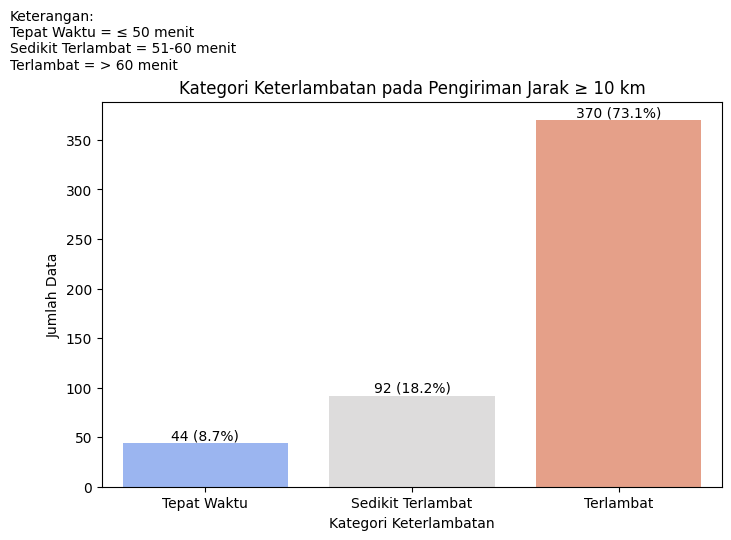

In [ ]:
df_jauh['Kategori_Keterlambatan'] = df_jauh['Delivery_Time_min'].apply(kategori_keterlambatan_jauh)
count_keterlambatan = df_jauh['Kategori_Keterlambatan'].value_counts().reindex(['Tepat Waktu', 'Sedikit Terlambat', 'Terlambat'])

plt.figure(figsize=(8,5))
ax = sns.barplot(x=count_keterlambatan.index, y=count_keterlambatan.values, palette='coolwarm')

plt.title('Kategori Keterlambatan pada Pengiriman Jarak ≥ 10 km')
plt.xlabel('Kategori Keterlambatan')
plt.ylabel('Jumlah Data')

total = count_keterlambatan.sum()
for i, v in enumerate(count_keterlambatan.values):
    persen = v / total * 100
    ax.text(i, v + max(count_keterlambatan.values)*0.01, f"{v} ({persen:.1f}%)", color='black', ha='center')

plt.figtext(0.01, 0.95,
            'Keterangan:\n'
            'Tepat Waktu = ≤ 50 menit\n'
            'Sedikit Terlambat = 51-60 menit\n'
            'Terlambat = > 60 menit',
            wrap=True, horizontalalignment='left', fontsize=10)

plt.show()


Interpretasi:
Sebagian besar pengiriman jarak ≥ 10 km mengalami keterlambatan, dengan 73.1% terlambat lebih dari 60 menit. Hanya 8.7% yang tepat waktu dan 18.2% sedikit terlambat. Perusahaan perlu meningkatkan efisiensi pengiriman jarak jauh melalui optimasi rute, manajemen waktu yang lebih baik, dan koordinasi dengan kurir.

##### Breakdown lagi dari segi kondisi cuaca berdasarkan keterlambatan?

In [ ]:
df_terlambat = df_jauh[df_jauh['Kategori_Keterlambatan'] == 'Terlambat']

<ipython-input-58-762be18a0940>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weather_count.index, y=weather_count.values, palette='Blues')


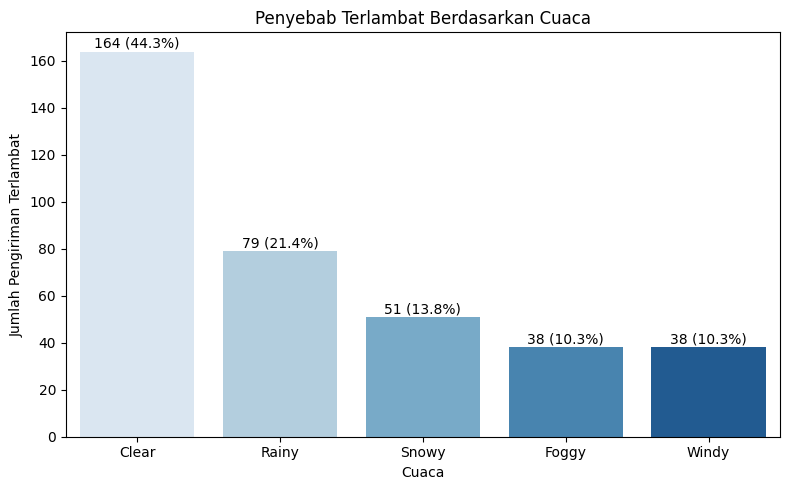

In [ ]:
weather_count = df_terlambat['Weather'].value_counts()

plt.figure(figsize=(8,5))
total_weather = weather_count.sum()
sns.barplot(x=weather_count.index, y=weather_count.values, palette='Blues')
plt.title('Penyebab Terlambat Berdasarkan Cuaca')
plt.xlabel('Cuaca')
plt.ylabel('Jumlah Pengiriman Terlambat')

for i, v in enumerate(weather_count.values):
    persen = v / total_weather * 100
    plt.text(i, v + max(weather_count.values)*0.01, f"{v} ({persen:.1f}%)", ha='center')

plt.tight_layout()
plt.show()


Interpretasi:

Cuaca cerah (Clear) menjadi faktor terbesar penyebab keterlambatan pengiriman, dengan 44.3% pengiriman terlambat. Cuaca hujan (Rainy) juga berkontribusi signifikan, yaitu 21.4%. Sementara itu, cuaca salju, kabut, dan berangin memiliki kontribusi yang lebih kecil, masing-masing sekitar 10-14%. Perusahaan perlu fokus pada pengelolaan pengiriman di semua kondisi cuaca, terutama untuk meminimalisir keterlambatan pada cuaca cerah dan hujan.

##### Dari Kondisi Terang, Bagaimana kondisi lalu lintas dan dari segi waktu harinya ?

In [ ]:
df_clear_terlambat = df_terlambat[df_terlambat['Weather'] == 'Clear']

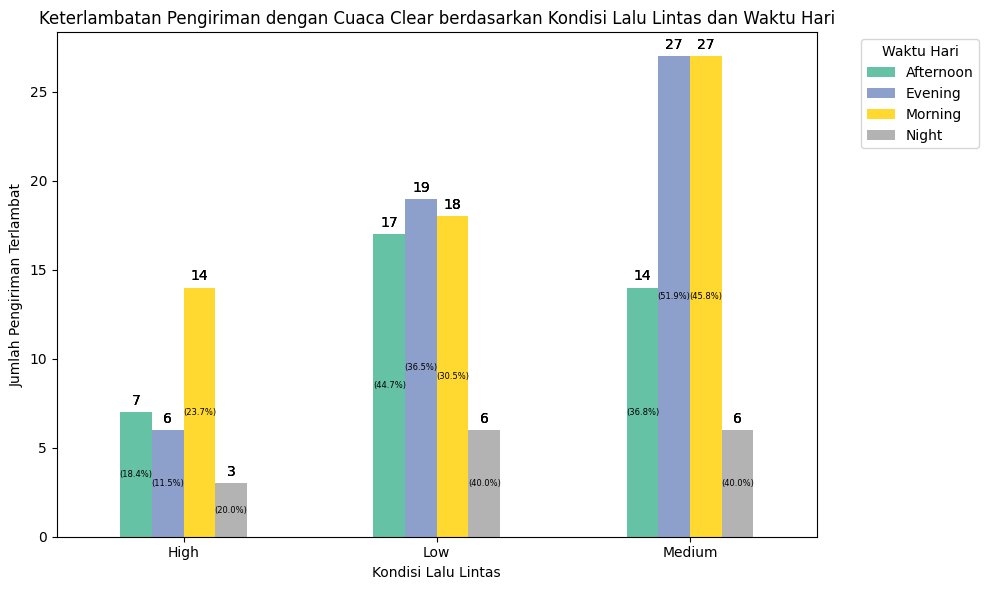

In [ ]:
# Hitung jumlah keterlambatan pengiriman berdasarkan kondisi lalu lintas dan waktu hari
traffic_time_clear_count = df_clear_terlambat.groupby(['Traffic_Level', 'Time_of_Day']).size().unstack()

# Visualisasi menggunakan barplot dengan warna yang lebih jelas
fig, ax = plt.subplots(figsize=(10,6))
traffic_time_clear_count.plot(kind='bar', stacked=False, colormap='Set2', ax=ax)

# Penambahan judul dan label
plt.title('Keterlambatan Pengiriman dengan Cuaca Clear berdasarkan Kondisi Lalu Lintas dan Waktu Hari')
plt.xlabel('Kondisi Lalu Lintas')
plt.ylabel('Jumlah Pengiriman Terlambat')

# Menambahkan label angka di atas batang dan label persentase di tengah vertikal
for container in ax.containers:
    total_height = sum([bar.get_height() for bar in container])  # Total tinggi batang dalam kelompok
    for bar in container:
        height = bar.get_height()
        persen = (height / total_height) * 100  # Menghitung persentase
        # Menambahkan angka di atas bar
        ax.bar_label(container, labels=[f'{int(bar.get_height())}' for bar in container], padding=3, label_type='edge')
        # Menambahkan persentase di tengah vertikal pada setiap bar
        y_position = bar.get_height() / 2
        ax.text(bar.get_x() + bar.get_width() / 2, y_position, f'({persen:.1f}%)',
                ha='center', va='center', fontsize=6, color='black')

# Menambahkan rotasi pada x-axis agar lebih jelas
plt.xticks(rotation=0)
# Menambahkan legenda di luar grafik
plt.legend(title='Waktu Hari', bbox_to_anchor=(1.05, 1), loc='upper left')
# Menyesuaikan layout agar lebih rapat
plt.tight_layout()

# Menampilkan grafik
plt.show()


Interpretasi:

Kondisi lalu lintas dengan tingkat kepadatan medium menunjukkan kontribusi yang signifikan terhadap keterlambatan pengiriman. Sebagian besar kejadian lalu lintas medium terjadi pada waktu pagi dan sore hari, yang memang merupakan jam sibuk dengan kepadatan kendaraan yang tinggi. Pada jam-jam tersebut, kemacetan menjadi faktor utama yang memperlambat laju pengiriman, sehingga mempengaruhi kecepatan dan ketepatan waktu pengantaran. Hal ini menunjukkan pentingnya perencanaan rute dan waktu pengiriman yang lebih efisien, terutama pada jam-jam sibuk untuk meminimalkan keterlambatan.

##### Breakdown berdasarkan tipe kendaraan, mengapa bisa terjadi keterlambatan ?

<ipython-input-62-00d6a17a2023>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vehicle_clear_count.index, y=vehicle_clear_count.values, palette='Greens')


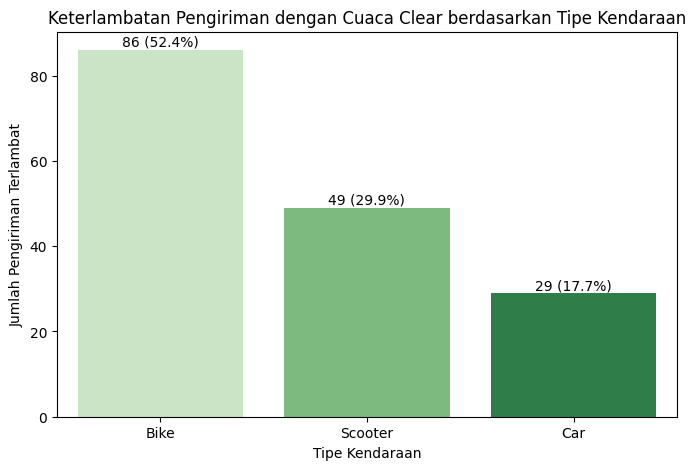

In [ ]:
vehicle_clear_count = df_clear_terlambat['Vehicle_Type'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=vehicle_clear_count.index, y=vehicle_clear_count.values, palette='Greens')

plt.title('Keterlambatan Pengiriman dengan Cuaca Clear berdasarkan Tipe Kendaraan')
plt.xlabel('Tipe Kendaraan')
plt.ylabel('Jumlah Pengiriman Terlambat')

total = vehicle_clear_count.sum()
for i, v in enumerate(vehicle_clear_count.values):
    persen = v / total * 100
    plt.text(i, v + max(vehicle_clear_count.values)*0.01, f"{v} ({persen:.1f}%)", ha='center')

plt.show()


Interpretasi:

Sepeda (Bike) menjadi kendaraan yang paling sering mengalami keterlambatan pengiriman, menyumbang lebih dari separuh total keterlambatan (52.4%). Scooter menyumbang sekitar 30% dari keterlambatan, sementara mobil (Car) mencatatkan jumlah keterlambatan paling sedikit, hanya 17.7%.

Ini menunjukkan bahwa untuk mengurangi keterlambatan, perusahaan mungkin perlu mempertimbangkan efisiensi penggunaan sepeda dan scooter, serta fokus pada optimasi penggunaan kendaraan yang lebih besar seperti mobil untuk pengiriman yang lebih cepat dan efisien.

In [ ]:
#Menghilangkan/drop Oder ID
df_clean = df_clean.drop(columns=['Order_ID'], errors='ignore')
df_clean.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


## Analisis Bivariat dan Statistika Deskriptif

In [ ]:
df_clean.to_csv('Data FTD Clean.csv')

### Statistika Deskriptif

In [ ]:
df_clean.describe()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,994.000000,994.000000,994.000000,994.000000
mean,10.016308,16.959759,4.582879,56.263581
std,5.684717,7.206240,2.875455,21.276034
min,0.590000,5.000000,0.000000,8.000000
25%,5.015000,11.000000,2.000000,41.000000
50%,10.150000,17.000000,5.000000,55.000000
75%,14.890000,23.000000,7.000000,71.000000
max,19.990000,29.000000,9.000000,116.000000


Interpretasi:
- Waktu persiapan rata-rata (10 menit) dan waktu pengantaran rata-rata (56 menit) menunjukkan bahwa sistem umumnya berjalan cukup efisien, tetapi ada variasi yang signifikan.

- Jarak pengantaran sangat bervariasi, dengan beberapa pengantaran sangat dekat (1 km) dan beberapa lainnya cukup jauh (hingga 19.9 km).

- Pengalaman kurir rata-rata adalah 4.5 tahun, tetapi ada beberapa kurir baru, yang tercermin dari pengalaman minimum 0 tahun.

### Analisis Bivariat - Scatterplot

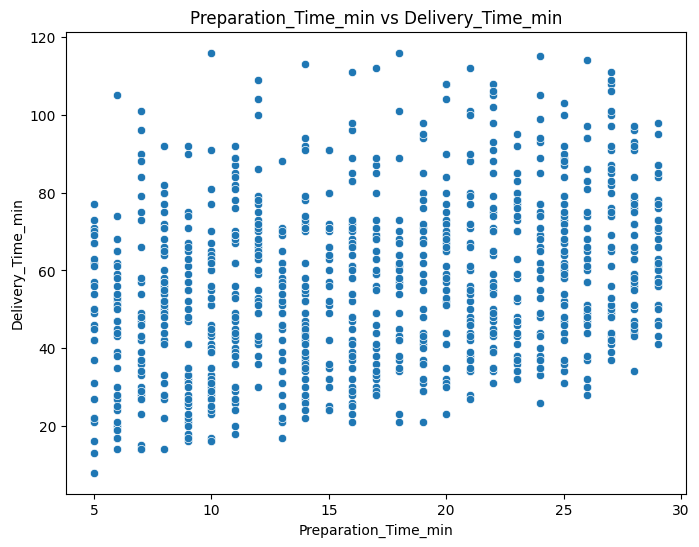

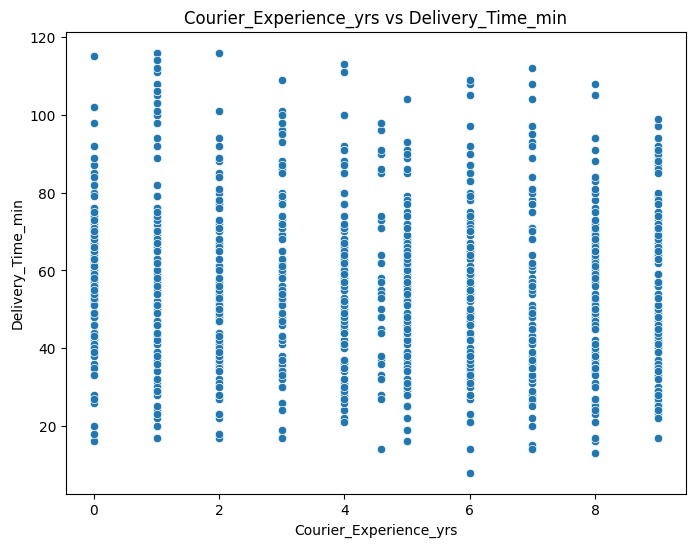

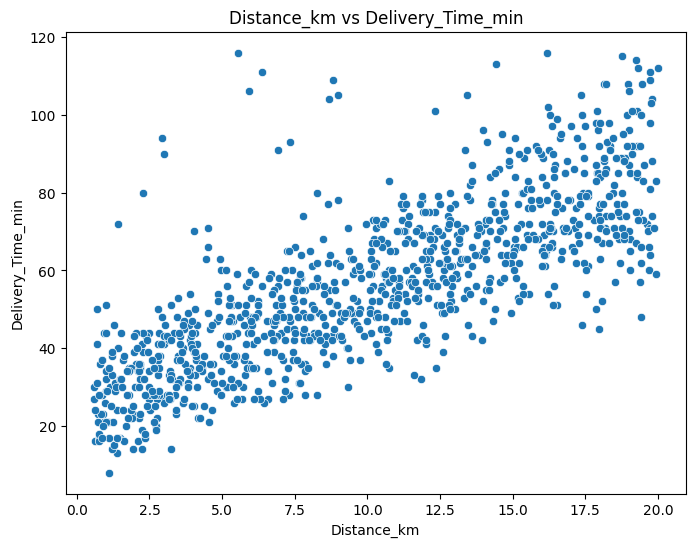

In [ ]:
# Daftar kolom X yang akan dipetakan ke sumbu X pada scatter plot
X_columns = ['Preparation_Time_min', 'Courier_Experience_yrs', 'Distance_km']

# Loop untuk membuat scatter plot untuk setiap fitur terhadap Y
for col in X_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_clean[col], y=df_clean['Delivery_Time_min'])
    plt.title(f'{col} vs Delivery_Time_min')
    plt.xlabel(col)
    plt.ylabel('Delivery_Time_min')
    plt.show()

Interpretasi:
- Korelasi antara variabel Preparation_Time_min vs Delivery_Time_min dan Courier_Experience_yrs vs Delivery_Time_min cenderung tidak membentuk korelasi positif atau negatif, hal ini memungkinkan kedua variabel tersebut lemah korelasinya dengan Delivery_time_min (**dalam artian hubungannya lemah**)
- Korelasi antara variabel Distance_km vs Delivery_Time_min cenderung menunjukkan korelasi positif ke atas,artinya, **ada hubungan nih dengan delivery_time_min**, sehingga semakin panjang jarak pengantaran maka semakin lama pula proses pengantarannya.

Perlu dicek nilai korelasinya, agar memperkuat argumen.

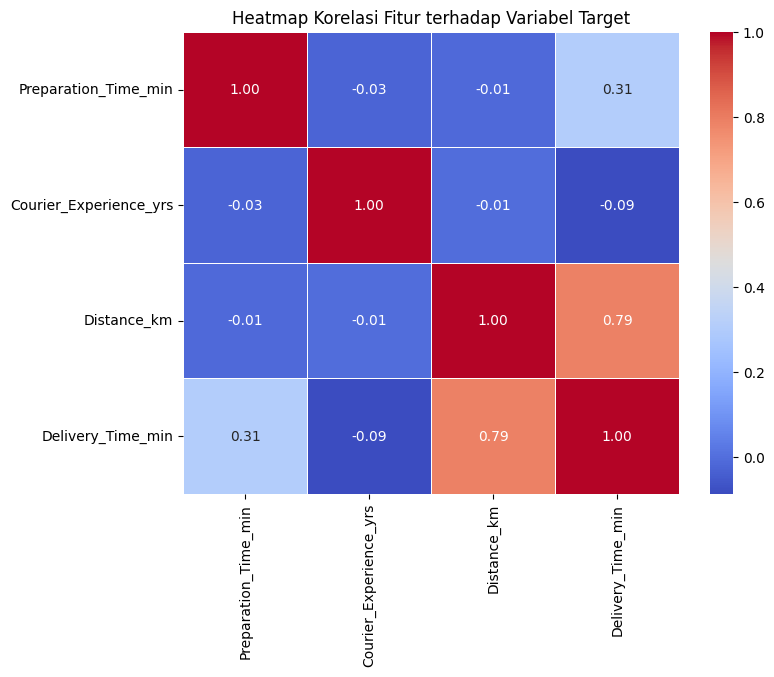

In [ ]:
# Pilih subset kolom yang diinginkan + target variabel
subset_columns = ['Preparation_Time_min', 'Courier_Experience_yrs', 'Distance_km', 'Delivery_Time_min']

# Menghitung matriks korelasi untuk subset kolom
corr_matrix_subset = df_clean[subset_columns].corr()

# Membuat heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Menambahkan judul
plt.title('Heatmap Korelasi Fitur terhadap Variabel Target')

# Menampilkan plot
plt.show()

Interpretasi:

Berdasarkan korelasi heatmap antara variabel Fitur dengan variabel Target, yaitu 'Preparation_Time_min', 'Courier_Experience_yrs', 'Distance_km' vs 'Delivery_Time_min':
- Nilai korelasinya **yang paling lemah** adalah **variabel 'Courier_Experience_yrs' terhadap 'Delivery_Time_min** , yaitu mendekati 0 (-0.09). Make sense, jika scatterplotnya tidak membentuk korelasi positif/negatif.
- Nilai korelasinya **yang lemah** adalah **variabel 'Preparation_Time_min' terhadap 'Delivery_Time_min'** , yaitu mendekati 0 (0.31). Make sense, jika scatterplotnya tidak membentuk korelasi positif/negatif.
- Nilai korelasinya **yang cukup kuat** adalah **variabel 'Distance_km' terhadap 'Delivery_Time_min'** , yaitu mendekati 0 (0.79). Make sense, jika membentuk korelasi positif, karena memang ada indikasi hubungan yang cukup kuat.

## Splitting Data

- Melakukan splitting data dengan membagi menjadi 80:20 (80 training dan 20 testing)
- Tidak perlu validasi data, karena nantinya akan menggunakan hypertuning parameter dengan **GridSearch-CV**

In [ ]:
X = df_clean.drop(columns=['Delivery_Time_min']).to_numpy()
y = df_clean[['Delivery_Time_min']].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape: (795, 7)
X_test shape : (199, 7)
y_train shape: (795,)
y_test shape : (199,)


In [ ]:
print(df_clean)

     Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0           7.93   Windy           Low   Afternoon      Scooter   
1          16.42   Clear        Medium     Evening         Bike   
2           9.52   Foggy           Low       Night      Scooter   
3           7.44   Rainy        Medium   Afternoon      Scooter   
4          19.03   Clear           Low     Morning         Bike   
..           ...     ...           ...         ...          ...   
995         8.50   Clear          High     Evening          Car   
996        16.28   Rainy           Low     Morning      Scooter   
997        15.62   Snowy          High     Evening      Scooter   
998        14.17   Clear           Low   Afternoon         Bike   
999         6.63   Foggy           Low       Night      Scooter   

     Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
0                      12                     1.0                 43  
1                      20                     2.0    

## Analisis Fitur/Korelasi

**Analisis Fitur** ini bertujuan untuk memilih variabel-variabel fitur yang signifikan dalam artian memang memengaruhi dengan vgariabel target. Sekaligus, tidak saling, multikolinearitas antar variabel fiturnya. Dengan menggunakan VIF dan korelasi heatmap akan bisa memilih variabel-variabel yg tidak saling multikolinearitas.

In [ ]:
# Buat list kolom setelah drop target dan 'OrderID'
columns = df_clean.drop(columns=['Delivery_Time_min']).columns.tolist()

# Ambil indeks dari kolom yang diinginkan
idx = [columns.index(col) for col in ['Preparation_Time_min', 'Courier_Experience_yrs', 'Distance_km']]

# Akses kolom numerik dari X_train
X_train_numerik = X_train[:, idx]

# Buat DataFrame baru
X_train_numerik_df = pd.DataFrame(X_train_numerik, columns=[columns[i] for i in idx])


In [ ]:
X_train_numerik_df

,Preparation_Time_min,Courier_Experience_yrs,Distance_km
0,25,0.0,12.0
1,22,5.0,7.34
2,16,3.0,3.64
3,19,8.0,3.97
4,12,6.0,19.04
...,...,...,...
790,17,6.0,14.89
791,5,6.0,4.55
792,21,5.0,4.05
793,9,7.0,13.6


In [ ]:
print(X_train_numerik_df.dtypes)

Preparation_Time_min      object
Courier_Experience_yrs    object
Distance_km               object
dtype: object


Karena berubah jadi object maka kita ubah bentuk numerik

In [ ]:
for col in X_train_numerik_df.columns:
    X_train_numerik_df[col] = pd.to_numeric(X_train_numerik_df[col], errors='coerce')

In [ ]:
# Kalkulasi Skor VIF

X = add_constant(X_train_numerik_df)

# Hitung VIF
skor_vif = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])],
                        index=X.columns).reset_index()
skor_vif.columns = ['feature', 'vif_score']

# Drop konstanta
skor_vif = skor_vif.loc[skor_vif.feature != 'const']
print(skor_vif)

                  feature  vif_score
1    Preparation_Time_min   1.004229
2  Courier_Experience_yrs   1.002618
3             Distance_km   1.002020


Interpretasi: VIFnya <10 bahkan <5, sehingga tidak ada indikasi multikolinearitas

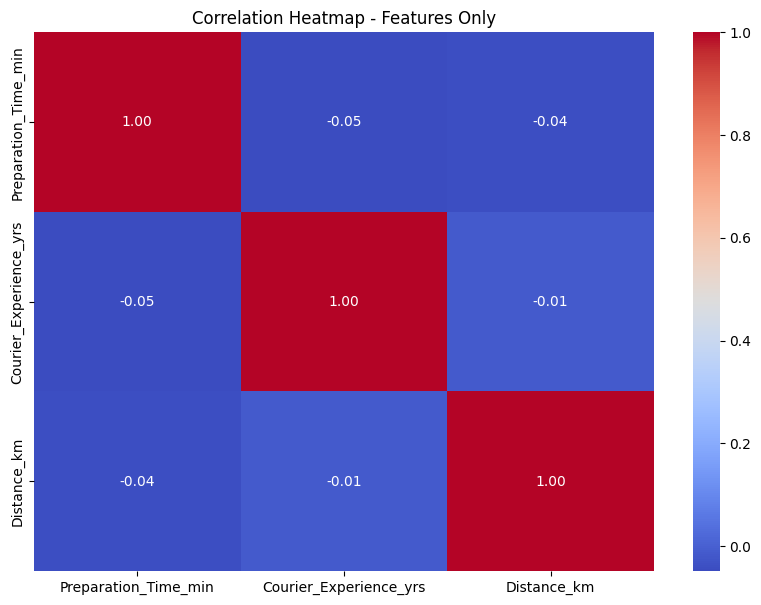

In [ ]:
# Korelasi Heatmap
corr = X_train_numerik_df.corr()

# Visualisasinya
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap - Features Only')
plt.show()

Interpretasi:
- Tresshold untuk indikasi multikolinearitas antar variabel fitur adalah r > 0,8
- Secara korelasi heatmap, tidak ada yang nilai korelasinya > 0,8. Maka, tidak ada indikasi multikolinearitas. Sehingga, tidak perlu didrop variabel.

## Encoding Data

Melakukan encoding data untuk analisis machine learning pada data kategorik. Varibel kategorinya adalah **kategori weather, traffic_level, Vehicle_Type, dan time_of_day.**

Karena keempat variabel tersebut kategorinya lebih dari 2, maka menggunakan **OHE** lebih cocok. **Mengapa demikian ?** -> tidak memberikan bobot atau urutan buatan, menyediakan representasi numerik yang bisa dibaca model, dan menghindari kesalahan asumsi statistik. Apalagi, ini casenya regresi jadi sangat cocok menggunakan OHE, konsepnya seperti **Regresi Dummy**

### Pengubahan ke DataFrame

In [ ]:
fitur = df_clean.drop(columns=['Delivery_Time_min']).columns
X_train = pd.DataFrame(X_train, columns=fitur)
X_test = pd.DataFrame(X_test, columns=fitur)
y_train = pd.DataFrame(y_train, columns=['Delivery_Time_min'])
y_test = pd.DataFrame(y_test, columns=['Delivery_Time_min'])

### Encoding Train

In [ ]:
# One-hot encode untuk setiap kolom pada X_train
ohe_dict = {}  # Menyimpan objek encoder untuk setiap kolom agar bisa digunakan untuk X_test

for col in ['Weather', 'Traffic_Level', 'Vehicle_Type', 'Time_of_Day']:
    ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')

    # Fit and transform untuk X_train
    smoking_ohe_train = ohe.fit_transform(X_train[[col]])

    # Mendapatkan nama fitur setelah encoding
    smoking_cols = ohe.get_feature_names_out([col])

    # Membuat DataFrame untuk X_train
    df_smoking_ohe_train = pd.DataFrame(smoking_ohe_train, columns=smoking_cols, index=X_train.index)

    # Menyimpan encoder untuk digunakan pada X_test
    ohe_dict[col] = ohe

    # Simpan encoder menggunakan pickle
    with open(f"{col}_ohe.pkl", "wb") as f:
        pickle.dump(ohe, f)

    # Menambahkannya ke X_train
    X_train = pd.concat([X_train, df_smoking_ohe_train], axis=1)

    # Menghapus kolom asli yang masih berupa string
    X_train = X_train.drop(columns=[col])

In [ ]:
X_train.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night
0,12.0,25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,7.34,22,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.64,16,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3.97,19,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,19.04,12,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Encoding Test

In [ ]:
# One-hot encode untuk X_test menggunakan encoder yang sama
for col in ['Weather', 'Traffic_Level', 'Vehicle_Type', 'Time_of_Day']:
    # Menggunakan encoder yang sudah di-fit pada X_train untuk transformasi X_test
    smoking_ohe_test = ohe_dict[col].transform(X_test[[col]])

    # Mendapatkan nama fitur yang sama seperti di X_train
    smoking_cols_test = ohe_dict[col].get_feature_names_out([col])

    # Membuat DataFrame untuk X_test
    df_smoking_ohe_test = pd.DataFrame(smoking_ohe_test, columns=smoking_cols_test, index=X_test.index)

    # Menambahkannya ke X_test
    X_test = pd.concat([X_test, df_smoking_ohe_test], axis=1)

    # Menghapus kolom asli yang masih berupa string
    X_test = X_test.drop(columns=[col])

In [ ]:
X_test.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night
0,2.67,17,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,11.44,20,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,4.94,28,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3.33,24,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4.97,17,9.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Scalling Data

Scaling data sangat diperlukan dalam beberapa analisis machine learning, terutama pada regresi atau model lain yang sensitif terhadap skala fitur. Model-model seperti regresi linier, logistik, KNN, atau SVM atau SVR sangat sensitif terhadap perbedaan skala antara fitur.

**Konsep Teori:**

Scaling memastikan bahwa setiap fitur berkontribusi secara setara dalam perhitungan model. Tanpa scaling, fitur dengan skala yang lebih besar (misalnya, jarak dalam kilometer) akan mendominasi perhitungan model dibandingkan dengan fitur yang skala-nya lebih kecil (misalnya, waktu dalam menit).

Scalling yang saya gunakan adalah **StandarScaler**. StandardScaler mengubah fitur sehingga memiliki mean = 0 dan standard deviation = 1, yang sangat berguna untuk model-model seperti Linear Regression dan Support Vector Regression (SVR) yang sensitif terhadap skala fitur. Selain itu, karena lebih cocok untuk data dengan distribusi yang tidak terbatas (misalnya, data dengan outliers atau data yang memiliki distribusi normal).

In [ ]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [ ]:
#kolom
numerik_scale = ['Preparation_Time_min', 'Courier_Experience_yrs', 'Distance_km']
non_numerik_df = [col for col in X_train_scaled.columns if col not in numerik_scale]

### Scalling Train

In [ ]:
scaler = StandardScaler()
# Melakukan scaling pada data numerik
numerik_scaled = scaler.fit_transform(X_train_scaled[numerik_scale])

In [ ]:
#gabung
X_train_scaled = pd.concat([
    X_train_scaled[non_numerik_df].reset_index(drop=True),
    pd.DataFrame(numerik_scaled, columns=numerik_scale)
], axis=1)

In [ ]:
X_train_scaled.head()

,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Preparation_Time_min,Courier_Experience_yrs,Distance_km
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.101566,-1.594840,0.315234
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.687567,0.138377,-0.512357
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.140430,-0.554910,-1.169457
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.273569,1.178307,-1.110851
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.692428,0.485020,1.565500


#### Penyimpanan Scaler

In [ ]:
# Menyimpan scaler ke dalam file .pkl
pickle.dump(scaler, open('scaler.pkl', 'wb'))

### Scalling Test

In [ ]:
numerik_scaled_2 = scaler.transform(X_test_scaled[numerik_scale])

In [ ]:
#gabung
X_test_scaled = pd.concat([
    X_test_scaled[non_numerik_df].reset_index(drop=True),
    pd.DataFrame(numerik_scaled_2, columns=numerik_scale)
], axis=1)

In [ ]:
X_test_scaled.head()

,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Preparation_Time_min,Courier_Experience_yrs,Distance_km
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.002430,0.485020,-1.341724
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.411568,-0.901553,0.215781
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.515564,-0.208266,-0.938584
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.963566,-0.901553,-1.224511
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.002430,1.524950,-0.933256


Interpretasi: Sudah terscalling dengan baik antara data training dan testing. Sehingga Lanjut ke Pemodellan + Evaluasi

In [ ]:
print(model.feature_names_in_)

# Data Modelling + Evaluasi

Karena prediksi regression dan bukan classification, maka tidak perlu pengeckan imbalanced.

Untuk metrik evaluasi yang akan saya gunakan dalam case prediksi ini adalah:
- MAE
- MAPE
- RMSE
- Nilai R^2
- Tambahan, Visualisasi line chart performa model antara actual dengan prediksi

Model yang akan saya gunakan adalah **Linear Regression, Random Forest Regression, Support Vector Regression, dan XGBoost Regression**

**Dengan skema**, membandingkan model yang terbaik berdasarkan evaluasi metrik yang terbaik yang mana untuk dijadikan prediksi proses pengantaran

**Menggunakan Hypertuning Parameter** untuk training model

## Persiapan Data

In [ ]:
# non scaled
X_train_non_scaled = X_train.copy()
X_test_non_scaled = X_test.copy()

# scaled
X_train_scaled = X_train_scaled.copy()
X_test_scaled = X_test_scaled.copy()

## Train

### Linear Regression

In [ ]:
# Linear Regression Model
lr = LinearRegression()

# Latih model pada data latih yang sudah diskalakan
best_lr = lr.fit(X_train_scaled, y_train)

# Prediksi menggunakan data latih yang sudah diskalakan (harus sama dengan data pelatihan)
y_pred_train = lr.predict(X_train_scaled)  # Pastikan menggunakan data latih yang diskalakan

# Evaluasi Model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, rmse, r2, mape

# Evaluasi Linear Regression pada data latih
mae_lr, mse_lr, rmse_lr, r2_lr, mape_lr = evaluate_model(y_train, y_pred_train)

# Membuat DataFrame untuk hasil evaluasi
evaluation_results = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_lr, mse_lr, rmse_lr, r2_lr * 100, mape_lr]
}

# Konversi ke DataFrame
df_evaluation = pd.DataFrame(evaluation_results)

# Menampilkan DataFrame sebagai tabel
df_evaluation

,Keterangan,Nilai
0,MAE,6.387303
1,MSE,96.012795
2,RMSE,9.798612
3,R2 (%),78.139935
4,MAPE (%),10.921686


### Random Forest Regression

In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# GridSearchCV untuk Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# GridSearchCV untuk Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Use X_train as it is (after OHE, before scaling) because RF is not sensitive to scaling
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Prediksi pada data latih
# Use X_train for prediction as it was used for training
y_pred_train_rf = best_rf.predict(X_train)

# Evaluasi Model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    # Ensure both y_true and y_pred are numpy arrays for element-wise operations
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true_np - y_pred_np) / (y_true_np + epsilon))) * 100
    return mae, mse, rmse, r2, mape

# Evaluasi Random Forest pada data latih
mae_rf, mse_rf, rmse_rf, r2_rf, mape_rf = evaluate_model(y_train, y_pred_train_rf)

# Membuat DataFrame untuk hasil evaluasi
evaluation_results_rf = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_rf, mse_rf, rmse_rf, r2_rf * 100, mape_rf]
}

# Konversi ke DataFrame
df_evaluation_rf = pd.DataFrame(evaluation_results_rf)

# Menampilkan DataFrame sebagai tabel
df_evaluation_rf

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,Keterangan,Nilai
0,MAE,3.957060
1,MSE,36.406918
2,RMSE,6.033815
3,R2 (%),91.710921
4,MAPE (%),49.005571


### Support Vector Regression

In [ ]:
# Tentukan parameter grid yang ingin diuji
param_grid = {
    'C': [0.1, 1, 10, 30, 60, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Jenis kernel yang digunakan
    'gamma': ['scale', 'auto']  # Parameter gamma
}

# Membuat objek SVR
svr = SVR()

# Implementasikan GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Latih model dengan GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Ambil model terbaik
best_svr = grid_search.best_estimator_

# Prediksi pada data latih yang sudah diskalakan menggunakan model terbaik
y_pred_train_svr = best_svr.predict(X_train_scaled)

# Evaluasi Model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    # Ensure both y_true and y_pred are numpy arrays for element-wise operations
    y_true_np = np.array(y_true) # Convert y_true to numpy array
    y_pred_np = np.array(y_pred)
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true_np - y_pred_np) / (y_true_np + epsilon))) * 100
    return mae, mse, rmse, r2, mape

# Convert y_train to numpy array before passing to evaluate_model
mae_svr, mse_svr, rmse_svr, r2_svr, mape_svr = evaluate_model(y_train.to_numpy(), y_pred_train_svr)

# Membuat DataFrame untuk hasil evaluasi
evaluation_results_svr = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_svr, mse_svr, rmse_svr, r2_svr * 100, mape_svr]
}

# Konversi ke DataFrame
df_evaluation_svr = pd.DataFrame(evaluation_results_svr)

# Menampilkan DataFrame sebagai tabel
df_evaluation_svr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

,Keterangan,Nilai
0,MAE,6.178433
1,MSE,99.021497
2,RMSE,9.950955
3,R2 (%),77.454917
4,MAPE (%),48.562548


### XGBoost Regression

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Jumlah pohon keputusan
    'learning_rate': [0.01, 0.1, 0.3],  # Kecepatan pembelajaran
    'max_depth': [3, 5, 7],  # Kedalaman maksimum pohon
    'subsample': [0.8, 1.0],  # Proporsi data yang digunakan untuk pelatihan
    'colsample_bytree': [0.8, 1.0]  # Proporsi fitur yang digunakan untuk pelatihan
}

# Membuat objek XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Implementasikan GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Latih model dengan GridSearchCV
grid_search_xgb.fit(X_train_scaled, y_train)

# Ambil model terbaik
best_xgb = grid_search_xgb.best_estimator_

# Prediksi pada data latih yang sudah diskalakan menggunakan model terbaik
y_pred_train_xgb = best_xgb.predict(X_train_scaled)

# Evaluasi Model
mae_xgb, mse_xgb, rmse_xgb, r2_xgb, mape_xgb = evaluate_model(y_train, y_pred_train_xgb)

# Membuat DataFrame untuk hasil evaluasi
evaluation_results_xgb = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_xgb, mse_xgb, rmse_xgb, r2_xgb * 100, mape_xgb]
}

# Konversi ke DataFrame
df_evaluation_xgb = pd.DataFrame(evaluation_results_xgb)

# Menampilkan DataFrame sebagai tabel
df_evaluation_xgb

,Keterangan,Nilai
0,MAE,5.423830
1,MSE,65.672699
2,RMSE,8.103869
3,R2 (%),85.047728
4,MAPE (%),48.933817


## Test

### Linear Regression

In [ ]:
# Prediksi pada data uji yang sudah diskalakan
y_pred_test = best_lr.predict(X_test_scaled)

# Evaluasi Linear Regression pada data uji
mae_lr_test, mse_lr_test, rmse_lr_test, r2_lr_test, mape_lr_test = evaluate_model(y_test, y_pred_test)

# Membuat DataFrame untuk hasil evaluasi pada data uji
evaluation_results_test = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_lr_test, mse_lr_test, rmse_lr_test, r2_lr_test * 100, mape_lr_test]
}

# Konversi ke DataFrame
df_evaluation_test = pd.DataFrame(evaluation_results_test)

# Menampilkan DataFrame sebagai tabel
df_evaluation_test

,Keterangan,Nilai
0,MAE,5.578447
1,MSE,73.931375
2,RMSE,8.598336
3,R2 (%),85.078227
4,MAPE (%),10.489133


### Random Forest Regression

In [ ]:
# Prediksi pada data uji yang sudah diskalakan
y_pred_test_rf = best_rf.predict(X_test)

# Evaluasi Random Forest pada data uji
mae_rf_test, mse_rf_test, rmse_rf_test, r2_rf_test, mape_rf_test = evaluate_model(y_test, y_pred_test_rf)

# Membuat DataFrame untuk hasil evaluasi pada data uji
evaluation_results_test_rf = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_rf_test, mse_rf_test, rmse_rf_test, r2_rf_test * 100, mape_rf_test]
}

# Konversi ke DataFrame
df_evaluation_test_rf = pd.DataFrame(evaluation_results_test_rf)

# Menampilkan DataFrame sebagai tabel
df_evaluation_test_rf

,Keterangan,Nilai
0,MAE,6.315412
1,MSE,88.947364
2,RMSE,9.431191
3,R2 (%),82.047508
4,MAPE (%),57.463395


### Support Vector Regression

In [ ]:
# Prediksi pada data uji yang sudah diskalakan
y_pred_test_svr = best_svr.predict(X_test_scaled)

# Evaluasi SVR pada data uji
mae_svr_test, mse_svr_test, rmse_svr_test, r2_svr_test, mape_svr_test = evaluate_model(y_test, y_pred_test_svr)

# Membuat DataFrame untuk hasil evaluasi pada data uji
evaluation_results_test_svr = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_svr_test, mse_svr_test, rmse_svr_test, r2_svr_test * 100, mape_svr_test]
}

# Konversi ke DataFrame
df_evaluation_test_svr = pd.DataFrame(evaluation_results_test_svr)

# Menampilkan DataFrame sebagai tabel
df_evaluation_test_svr


,Keterangan,Nilai
0,MAE,5.299613
1,MSE,74.141156
2,RMSE,8.610526
3,R2 (%),85.035886
4,MAPE (%),57.468101


### XGBoost Regression

In [ ]:
# Prediksi pada data uji yang sudah diskalakan
y_pred_test_xgb = best_xgb.predict(X_test_scaled)

# Evaluasi XGBoost pada data uji
mae_xgb_test, mse_xgb_test, rmse_xgb_test, r2_xgb_test, mape_xgb_test = evaluate_model(y_test, y_pred_test_xgb)

# Membuat DataFrame untuk hasil evaluasi pada data uji
evaluation_results_test_xgb = {
    'Keterangan': ['MAE', 'MSE', 'RMSE', 'R2 (%)', 'MAPE (%)'],
    'Nilai': [mae_xgb_test, mse_xgb_test, rmse_xgb_test, r2_xgb_test * 100, mape_xgb_test]
}

# Konversi ke DataFrame
df_evaluation_test_xgb = pd.DataFrame(evaluation_results_test_xgb)

# Menampilkan DataFrame sebagai tabel
df_evaluation_test_xgb

,Keterangan,Nilai
0,MAE,5.910279
1,MSE,84.594307
2,RMSE,9.197516
3,R2 (%),82.926095
4,MAPE (%),57.937935


## Evaluation

In [ ]:
evaluation_results = {
    'Model Train': ['Linear Regression', 'Random Forest', 'SVR', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_svr, rmse_xgb],
    'MAE': [mae_lr, mae_rf, mae_svr, mae_xgb],
    'MAPE (%)': [mape_lr, mape_rf, mape_svr, mape_xgb],
    'R² (%)': [r2_lr * 100, r2_rf * 100, r2_svr * 100, r2_xgb * 100]
}

# Konversi ke DataFrame
df_evaluation_full = pd.DataFrame(evaluation_results)

# Menampilkan DataFrame sebagai tabel
df_evaluation_full.to_excel('Hasil Training_Metrik.xlsx')

In [ ]:
evaluation_results_test = {
    'Model Test': ['Linear Regression', 'Random Forest', 'SVR', 'XGBoost'],
    'RMSE': [rmse_lr_test, rmse_rf_test, rmse_svr_test, rmse_xgb_test],
    'MAE': [mae_lr_test, mae_rf_test, mae_svr_test, mae_xgb_test],
    'MAPE (%)': [mape_lr_test, mape_rf_test, mape_svr_test, mape_xgb_test],
    'R² (%)': [r2_lr_test * 100, r2_rf_test * 100, r2_svr_test * 100, r2_xgb_test * 100]
}

# Konversi ke DataFrame
df_evaluation_full_test = pd.DataFrame(evaluation_results_test)

# Menampilkan DataFrame sebagai tabel
df_evaluation_full_test.to_excel('Hasil Testing_Metrik.xlsx')

In [ ]:
#gabung
print(df_evaluation_full)
print(df_evaluation_full_test)

         Model Train      RMSE       MAE   MAPE (%)     R² (%)
0  Linear Regression  9.798612  6.387303  10.921686  78.139935
1      Random Forest  6.033815  3.957060  49.005571  91.710921
2                SVR  9.950955  6.178433  48.562548  77.454917
3            XGBoost  8.103869  5.423830  48.933817  85.047728
          Model Test      RMSE       MAE   MAPE (%)     R² (%)
0  Linear Regression  8.598336  5.578447  10.489133  85.078227
1      Random Forest  9.431191  6.315412  57.463395  82.047508
2                SVR  8.610526  5.299613  57.468101  85.035886
3            XGBoost  9.197516  5.910279  57.937935  82.926095


Interpretasi:

**Dari Segi Kebaikan Model**

- **Linear Regression**: Cukup baik di pelatihan, tapi sedikit menurun di pengujian (78.14% → 85.08%). indikasi overfitting, karena GAPnya sekitar 7% an.

- **Random Forest**: Sangat baik di pelatihan, namun ada penurunan signifikan di pengujian (91.71% → 82.04%). Cederung overfitting karena GAPnya sekitar 9% an.

- **SVR**: mengalami kenaikan dari pelatihan ke pengujian. (77.45% → 85.03%). Indikasi overfitting sekitar 8% an

- **XGBoost**: Sangat baik di pelatihan (85.04%) tapi menurun sedikit di pengujian (82.92%), indikasi sedikit overfitting.

**Dilihat dari segi RMSE dan MAPE**, yang semakin kecil menunjukkan model yang lebih baik. Berdasarkan metrik tersebut, Linear Regression adalah model terbaik di antara keempat model yang diuji. RMSE pada Linear Regression lebih kecil dari **10**, dan MAPE sekitar *10%*, yang menunjukkan kesalahan model relatif kecil dan akurat. **Penurunan nilai RMSE dan MAPE** dari data pelatihan (train) ke data pengujian (test) semakin kecil, yang mengindikasikan bahwa **Linear Regression mampu menggeneralisasi dengan baik tanpa adanya overfitting**.

- **Untuk model lain**, penurunan MAPE yang cukup besar (sekitar 50%) menunjukkan adanya overfitting, yang mengindikasikan model tidak mampu beradaptasi dengan baik pada data yang belum pernah dilihat sebelumnya.

- **Dari segi RMSE**, **Random Forest** menunjukkan kenaikan (dari 6 ke 9.4), yang menunjukkan penurunan akurasi dan performa yang tidak cukup baik. **SVR** menunjukkan penurunan RMSE (dari 9.9 ke 8.6), yang lebih baik, namun masih kalah dibandingkan Linear Regression. **XGBoost** menunjukkan kenaikan dengan RMSE dari 8.1 ke 9.1.

Dengan Demikian,

**Linear Regression** terpilih karena data yang digunakan cocok dengan model yang lebih sederhana. Model sederhana seperti Linear Regression lebih efektif pada data yang tidak terlalu kompleks atau memiliki banyak fitur yang saling berinteraksi. Selain itu, Linear Regression meskipun tidak terlalu overfitting nilai kebaikan modelnya, namun tingkat kesalahannya tidak cukup besar dibandingkan model yang lain. Karena, ingin meminimalkan kesalahan dimana sanga memengaruhi hasil prediksinya, maka dipilih yang erronya kecil.

### Line Chart Prediksi vs Aktual untuk Linear Regression

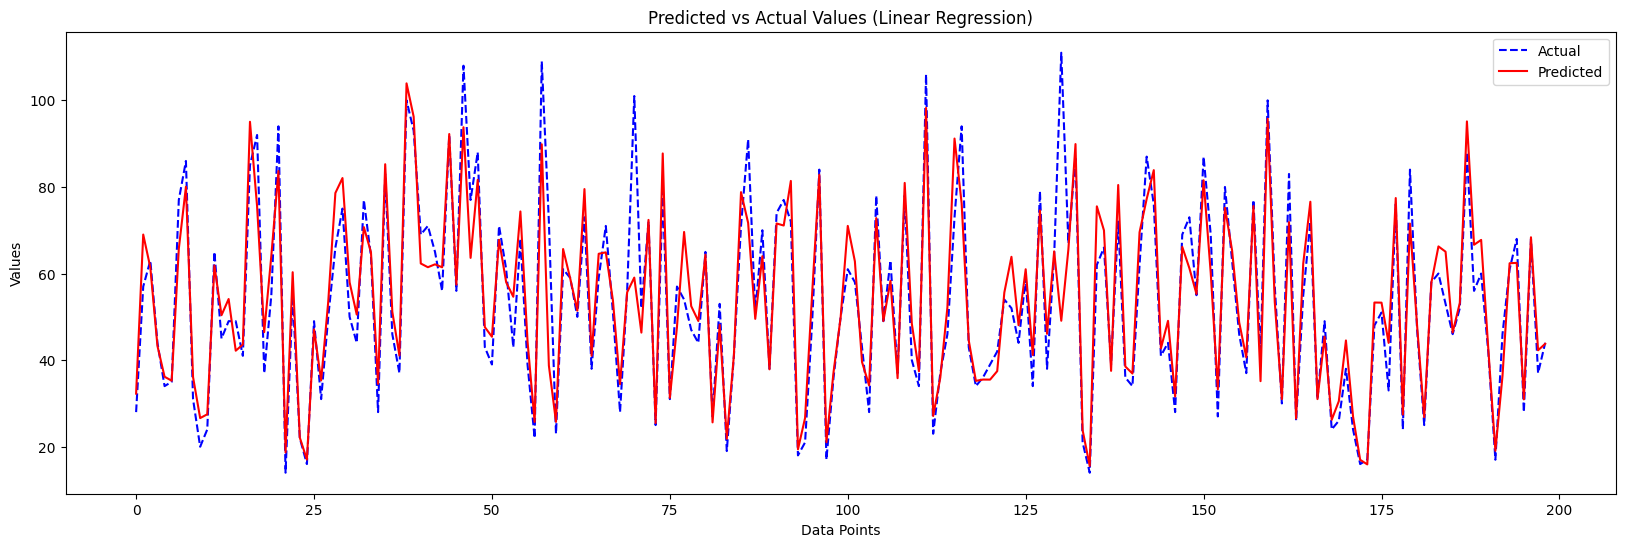

In [ ]:
import matplotlib.pyplot as plt

# Misal y_test adalah data aktual dan y_pred adalah prediksi dari model Linear Regression
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual', color='blue', linestyle='--')  # Garis aktual
plt.plot(y_pred_test, label='Predicted', color='red', linestyle='-')  # Garis prediksi

plt.title('Predicted vs Actual Values (Linear Regression)')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.show()


Interpretasi:
- Nilai prediksi (garis merah) mengikuti nilai aktual (garis putus-putus biru) dengan cukup baik, menunjukkan bahwa model Regresi Linier dapat menangkap pola dasar dalam data dengan baik. Kemudian, adanya fluktuansi menunjukkan bahwa model dapat mengikuti pola/tren. Selain itu, karena prediksinya semakin mirip dengan aktualnya maka dipastikan model dapat memprediksi dengan semakin akurat.
- Secara keseluruhan, grafik ini menunjukkan bahwa model memiliki kecocokan yang baik dengan data, meskipun terdapat sedikit kesalahan.

### Penyimpanan Model Linear Regression

In [ ]:
# Menyimpan model ke file dengan pickle
with open('/content/Model Linear Regression.pkl', 'wb') as file:
    pickle.dump(best_lr, file)

# Conlusion dan Rekomendasi

Conclusion:

Jarak tempuh merupakan salah satu faktor utama yang memengaruhi waktu pengiriman, di mana semakin jauh jarak yang ditempuh, semakin besar kemungkinan terjadinya keterlambatan. Selain itu, kondisi cuaca dan lalu lintas, terutama pada jam-jam sibuk seperti pagi dan sore hari, turut memperburuk kecepatan pengantaran. Tipe kendaraan kurir juga berperan penting, di mana kendaraan yang lebih kecil seperti sepeda dan scooter lebih rentan terhadap keterlambatan pada pengiriman jarak jauh, apalagi bila cuaca dan lalu lintas tidak mendukung.

**Intinya, kombinasi faktor-faktor tersebut yang memengaruhi keterlambatan, jadi tidak hanya satu faktor saja.**

Rekomendasi:
- Perusahaan perlu fokus pada optimasi rute pengiriman, terutama untuk jarak jauh, agar mengurangi waktu tempuh dan keterlambatan.
- Jadwalkan pengiriman lebih awal saat potensi hujan tinggi, terutama untuk jarak jauh.
- Tugaskan kurir berpengalaman di waktu dan area rawan keterlambatan.
- Menggunakan kendaraan yang lebih besar seperti mobil untuk pengiriman jarak jauh akan lebih efisien dan mengurangi dampak buruk cuaca serta kondisi lalu lintas. Atau bisa juga motor yang lebih cepat dibandingkan sepeda.
- Pemantauan kondisi lalu lintas dan cuaca secara real-time dapat membantu dalam pengambilan keputusan yang lebih tepat terkait dengan estimasi waktu pengiriman, sehingga mengurangi risiko keterlambatan yang tidak terduga.
- Sampaikan estimasi waktu pengiriman yang lebih realistis kepada pelanggan saat kondisi tidak ideal, seperti cuaca buruk atau lalu lintas padat. Berikan pemberitahuan secara proaktif mengenai potensi keterlambatan, agar pelanggan tetap merasa dihargai dan memiliki ekspektasi yang sesuai.
- Dengan batas waktu pengiriman satu jam, perusahaan perlu mempertimbangkan waktu tambahan saat menghadapi cuaca buruk atau jarak tempuh yang jauh, demi menjaga kualitas layanan dan kenyamanan kurir.
- Implementasikan prediksi waktu pengantaran makanan guna sebagai estimasi kurir saat mengantar agar meminimalkan resiko keterlambatan.